In [22]:
%pip install langchain-openai langgraph pandas numpy openpyxl ragas tabulate scikit-learn seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
%pip install -qU langchain-chroma

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [24]:
%pip install chardet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
    azure_endpoint="",
    azure_deployment="gpt-4o-mini",
    api_version="2024-08-01-preview",
    api_key=""
    
)

In [ ]:
from langchain_openai import AzureOpenAIEmbeddings

embeddings = AzureOpenAIEmbeddings(
    azure_endpoint = "",
    azure_deployment="text-embedding-3-large",
    api_version="2025-02-01-preview",
    api_key=""
)

In [27]:
from langchain_chroma import Chroma

vector_store = Chroma(embedding_function=embeddings)

In [28]:
#Load Data

from langchain_community.document_loaders import DirectoryLoader
from langchain.document_loaders import TextLoader

text_loader_kwargs = {"autodetect_encoding": True}
loader = DirectoryLoader("data/",glob="**/*.txt", show_progress=True, loader_cls=TextLoader, loader_kwargs=text_loader_kwargs)
docs = loader.load()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 232/232 [00:04<00:00, 53.05it/s]


In [29]:
import time
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=0)
all_splits = text_splitter.split_documents(docs)


batch_size = 50  
for i in range(0, len(all_splits), batch_size):
    batch = all_splits[i:i + batch_size]
    try:
        index_chunks = vector_store.add_documents(documents=batch)
    except RateLimitError:
        print("Rate Limit erreicht, warte 60 Sekunden...")
        time.sleep(60) 
        index_chunks = vector_store.add_documents(documents=batch)

In [31]:
from langchain_core.runnables import RunnablePassthrough
from langchain import hub
from langchain_core.output_parsers import StrOutputParser


retriever = vector_store.as_retriever()
prompt = hub.pull("rlm/rag-prompt")


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)



In [32]:
#Vertragsnamen extrahieren
import os 
contracts = [f.replace(".txt", "") for f in os.listdir("data/") if f.endswith(".txt")]
print(f"Anzahl Verträge: {len(contracts)}")

question_templates = [
    "Does the {contract} contract contain an exception or carve-out to any competitive restriction, allowing certain competitive activities or partnerships that would otherwise be prohibited, and if so, does it specify the activities or partnerships allowed?",
    "Does the {contract} contract include a clause that restricts a party from competing or engaging in a business activity that competes with the other party, and if so, does it specify a time frame or geographic area for this restriction?",
    "Does the {contract} contract grant one party exclusive rights to provide certain goods or services, and if so, does it also prevent that party from entering into similar agreements with third parties?",
    "Is there a provision in the {contract} contract that prohibits a party from soliciting or doing business with the customers or clients of the other party, and if so, does it specify a duration for this prohibition?"
]

multi_hop_q = []

for contract in contracts:
    for template in question_templates:
        question = template.format(contract=contract)
        multi_hop_q.append({"contract":contract, "question":question})

print(f"Anzahl fragen: {len(multi_hop_q)}")
for i, q in enumerate(multi_hop_q, 1):
    print(f"{i}. {q['question']} (Vertrag: {q['contract']})")



Anzahl Verträge: 232
Anzahl fragen: 928
1. Does the 2ThemartComInc_19990826_10-12G_EX-10.10_6700288_EX-10.10_Co-Branding Agreement_ Agency Agreement contract contain an exception or carve-out to any competitive restriction, allowing certain competitive activities or partnerships that would otherwise be prohibited, and if so, does it specify the activities or partnerships allowed? (Vertrag: 2ThemartComInc_19990826_10-12G_EX-10.10_6700288_EX-10.10_Co-Branding Agreement_ Agency Agreement)
2. Does the 2ThemartComInc_19990826_10-12G_EX-10.10_6700288_EX-10.10_Co-Branding Agreement_ Agency Agreement contract include a clause that restricts a party from competing or engaging in a business activity that competes with the other party, and if so, does it specify a time frame or geographic area for this restriction? (Vertrag: 2ThemartComInc_19990826_10-12G_EX-10.10_6700288_EX-10.10_Co-Branding Agreement_ Agency Agreement)
3. Does the 2ThemartComInc_19990826_10-12G_EX-10.10_6700288_EX-10.10_Co-Bran

In [33]:
#Antworten generieren
results = []

for q in multi_hop_q:
    question = q["question"]
    answer = rag_chain.invoke(f"Answer in two parts: (1) Yes/No for the first condition, (2) details for the second condition. {question}")
    results.append({"contract": q["contract"], "question": question, "rag_answer": answer})
    print(f"Frage: {question}")
    print(f"Antwort: {answer}\n")
    

    

Frage: Does the 2ThemartComInc_19990826_10-12G_EX-10.10_6700288_EX-10.10_Co-Branding Agreement_ Agency Agreement contract contain an exception or carve-out to any competitive restriction, allowing certain competitive activities or partnerships that would otherwise be prohibited, and if so, does it specify the activities or partnerships allowed?
Antwort: (1) Yes. (2) The contract specifies that CNET can enter into two additional agreements with Competing Computer Products Retailers for displaying permanent links or promotions on CNET sites, while allowing for standard advertisements and certain promotions within specified services.

Frage: Does the 2ThemartComInc_19990826_10-12G_EX-10.10_6700288_EX-10.10_Co-Branding Agreement_ Agency Agreement contract include a clause that restricts a party from competing or engaging in a business activity that competes with the other party, and if so, does it specify a time frame or geographic area for this restriction?
Antwort: (1) Yes. (2) The contr

Frage: Is there a provision in the ADIANUTRITION,INC_04_01_2005-EX-10.D2-RESELLER AGREEMENT contract that prohibits a party from soliciting or doing business with the customers or clients of the other party, and if so, does it specify a duration for this prohibition?
Antwort: (1) Yes. (2) There is a provision that prohibits the Distributor from soliciting or interfering with the business relations of the Company or its affiliates for a period of eighteen (18) months after the term of the Agreement, and the Distributor also agrees not to solicit customers for a competitive product during that time.

Frage: Does the ADUROBIOTECH,INC_06_02_2020-EX-10.7-CONSULTING AGREEMENT(1) contract contain an exception or carve-out to any competitive restriction, allowing certain competitive activities or partnerships that would otherwise be prohibited, and if so, does it specify the activities or partnerships allowed?
Antwort: (1) Yes. (2) The agreement prohibits the Consultant from engaging in any co

Frage: Does the AIRSPANNETWORKSINC_04_11_2000-EX-10.5-Distributor Agreement contract grant one party exclusive rights to provide certain goods or services, and if so, does it also prevent that party from entering into similar agreements with third parties?
Antwort: (1) Yes. (2) The contract grants the Distributor exclusive rights to market the Airspan Products and prevents the Distributor from representing or marketing products that compete with Airspan's offerings without Airspan's prior written consent during the term of the agreement and for three months afterward.

Frage: Is there a provision in the AIRSPANNETWORKSINC_04_11_2000-EX-10.5-Distributor Agreement contract that prohibits a party from soliciting or doing business with the customers or clients of the other party, and if so, does it specify a duration for this prohibition?
Antwort: (1) Yes. (2) The contract prohibits the Distributor from soliciting any customer or potential customer of the Company to purchase a competitive 

Frage: Does the AMBASSADOREYEWEARGROUPINC_11_17_1997-EX-10.28-ENDORSEMENT AGREEMENT contract include a clause that restricts a party from competing or engaging in a business activity that competes with the other party, and if so, does it specify a time frame or geographic area for this restriction?
Antwort: (1) Yes. (2) The contract specifies that the Endorser shall not provide endorsements for competing products during the term of the agreement and for one year after its expiration or termination. The geographical scope of the restriction is not explicitly mentioned.

Frage: Does the AMBASSADOREYEWEARGROUPINC_11_17_1997-EX-10.28-ENDORSEMENT AGREEMENT contract grant one party exclusive rights to provide certain goods or services, and if so, does it also prevent that party from entering into similar agreements with third parties?
Antwort: (1) Yes.  
(2) The agreement prohibits ABG from granting similar rights to any other party for the purpose of promoting or endorsing competitive produ

Frage: Does the Antares Pharma, Inc. - Manufacturing Agreement contract contain an exception or carve-out to any competitive restriction, allowing certain competitive activities or partnerships that would otherwise be prohibited, and if so, does it specify the activities or partnerships allowed?
Antwort: (1) Yes. (2) The provided context does not specify any competitive activities or partnerships that are allowed, so further details on any specific carve-outs are not available.

Frage: Does the Antares Pharma, Inc. - Manufacturing Agreement contract include a clause that restricts a party from competing or engaging in a business activity that competes with the other party, and if so, does it specify a time frame or geographic area for this restriction?
Antwort: (1) No. (2) The retrieved context does not indicate any clause that restricts a party from competing or engaging in competing business activities, nor does it specify a time frame or geographic area for such a restriction.

Frag

Frage: Is there a provision in the ASHWORTHINC_01_29_1999-EX-10.(D)-PROMOTION AGREEMENT AND NANTZ COMMUNICATIONS, INC. contract that prohibits a party from soliciting or doing business with the customers or clients of the other party, and if so, does it specify a duration for this prohibition?
Antwort: (1) No. (2) The retrieved context does not provide any specific provision regarding prohibition on soliciting or doing business with the customers or clients of the other party, nor does it mention a duration for such prohibition.

Frage: Does the ATHENSBANCSHARESCORP_11_02_2009-EX-1.2-AGENCY AGREEMENT , 2009 contract contain an exception or carve-out to any competitive restriction, allowing certain competitive activities or partnerships that would otherwise be prohibited, and if so, does it specify the activities or partnerships allowed?
Antwort: (1) No. (2) The provided context does not indicate any specific exception or carve-out for competitive restrictions, nor specifies any allowed

Frage: Does the AzulSa_20170303_F-1A_EX-10.3_9943903_EX-10.3_Maintenance Agreement1 contract grant one party exclusive rights to provide certain goods or services, and if so, does it also prevent that party from entering into similar agreements with third parties?
Antwort: (1) Yes. (2) The contract grants exclusive rights to one party for certain goods or services but does not prevent that party from entering into similar agreements with third parties.

Frage: Is there a provision in the AzulSa_20170303_F-1A_EX-10.3_9943903_EX-10.3_Maintenance Agreement1 contract that prohibits a party from soliciting or doing business with the customers or clients of the other party, and if so, does it specify a duration for this prohibition?
Antwort: (1) Yes. (2) The contract specifies a "Non-Solicit Period" lasting three years after the Closing Date, during which parties are prohibited from soliciting or recruiting employees of the Combined Business.

Frage: Does the BABCOCK_WILCOXENTERPRISES,INC_08

Frage: Does the BEYONDCOMCORP_08_03_2000-EX-10.2-CO-HOSTING AGREEMENT contract contain an exception or carve-out to any competitive restriction, allowing certain competitive activities or partnerships that would otherwise be prohibited, and if so, does it specify the activities or partnerships allowed?
Antwort: (1) Yes. (2) The contract allows for a hot link to internet locations specified by the Co-Host from which non-competitor goods may be sold, but explicitly prohibits links to sites selling competitor's goods. The exception applies specifically to co-hosting rights and requires compliance with the agreement's specifications.

Frage: Does the BEYONDCOMCORP_08_03_2000-EX-10.2-CO-HOSTING AGREEMENT contract include a clause that restricts a party from competing or engaging in a business activity that competes with the other party, and if so, does it specify a time frame or geographic area for this restriction?
Antwort: (1) Yes. (2) The contract specifies a Non-Competition Period of fi

Frage: Is there a provision in the BIOCEPTINC_08_19_2013-EX-10-COLLABORATION AGREEMENT contract that prohibits a party from soliciting or doing business with the customers or clients of the other party, and if so, does it specify a duration for this prohibition?
Antwort: (1) Yes. (2) The contract includes a non-solicitation provision that prohibits each party from soliciting the other party's employees for a certain period starting from the Effective Date, although the specific duration is redacted.

Frage: Does the BIOFRONTERAAG_04_29_2019-EX-4.17-SUPPLY AGREEMENT contract contain an exception or carve-out to any competitive restriction, allowing certain competitive activities or partnerships that would otherwise be prohibited, and if so, does it specify the activities or partnerships allowed?
Antwort: (1) Yes. (2) The contract includes conditions regarding the enforcement of Licensed Patents against suspected competitive infringements, allowing certain actions but requiring prior wri

Frage: Does the BLACKBOXSTOCKSINC_08_05_2014-EX-10.1-DISTRIBUTOR AGREEMENT contract grant one party exclusive rights to provide certain goods or services, and if so, does it also prevent that party from entering into similar agreements with third parties?
Antwort: (1) Yes. (2) The contract grants the Distributor exclusive rights to sell and distribute Products within the specified Market, and it does allow the Distributor to sell in markets without another exclusive distributor, implying limitations on entering similar agreements with third parties only in those exclusive markets.

Frage: Is there a provision in the BLACKBOXSTOCKSINC_08_05_2014-EX-10.1-DISTRIBUTOR AGREEMENT contract that prohibits a party from soliciting or doing business with the customers or clients of the other party, and if so, does it specify a duration for this prohibition?
Antwort: (1) Yes. (2) The contract prohibits the Distributor from soliciting or doing business with the customers or clients of the Company f

Frage: Does the BravatekSolutionsInc_20170418_8-K_EX-10.1_10205739_EX-10.1_Reseller Agreement contract grant one party exclusive rights to provide certain goods or services, and if so, does it also prevent that party from entering into similar agreements with third parties?
Antwort: (1) Yes. (2) The contract grants the Reseller exclusive rights to provide certain Company Products within a specified territory, but it does not indicate that the Reseller is prevented from entering into similar agreements with third parties.

Frage: Is there a provision in the BravatekSolutionsInc_20170418_8-K_EX-10.1_10205739_EX-10.1_Reseller Agreement contract that prohibits a party from soliciting or doing business with the customers or clients of the other party, and if so, does it specify a duration for this prohibition?
Antwort: (1) No. (2) The provided context does not mention any provision that prohibits a party from soliciting or doing business with the customers or clients of the other party, nor

Frage: Does the CHANGEPOINTCORP_03_08_2000-EX-10.6-LICENSE AND HOSTING AGREEMENT contract grant one party exclusive rights to provide certain goods or services, and if so, does it also prevent that party from entering into similar agreements with third parties?
Antwort: (1) Yes. (2) The agreement grants exclusive rights to provide certain goods or services but includes provisions that can make this exclusivity non-exclusive under specific conditions, such as breaches of the agreement or failure to meet revenue targets. Thus, this could allow the party to enter into similar agreements with third parties under certain circumstances.

Frage: Is there a provision in the CHANGEPOINTCORP_03_08_2000-EX-10.6-LICENSE AND HOSTING AGREEMENT contract that prohibits a party from soliciting or doing business with the customers or clients of the other party, and if so, does it specify a duration for this prohibition?
Antwort: (1) Yes. (2) The contract prohibits the Consultant from soliciting or doing

Frage: Does the CoherusBiosciencesInc_20200227_10-K_EX-10.29_12021376_EX-10.29_Development Agreement contract include a clause that restricts a party from competing or engaging in a business activity that competes with the other party, and if so, does it specify a time frame or geographic area for this restriction?
Antwort: (1) Yes. (2) The contract includes a non-solicitation clause that restricts either party from soliciting employees of the other party for a specified period starting from the Effective Date, although the exact duration and geographic area are redacted in the provided excerpt.

Frage: Does the CoherusBiosciencesInc_20200227_10-K_EX-10.29_12021376_EX-10.29_Development Agreement contract grant one party exclusive rights to provide certain goods or services, and if so, does it also prevent that party from entering into similar agreements with third parties?
Antwort: (1) No. (2) The contract states that while Bioeq has certain rights and responsibilities regarding the De

Frage: Does the DigitalCinemaDestinationsCorp_20111220_S-1_EX-10.10_7346719_EX-10.10_Affiliate Agreement contract contain an exception or carve-out to any competitive restriction, allowing certain competitive activities or partnerships that would otherwise be prohibited, and if so, does it specify the activities or partnerships allowed?
Antwort: (1) Yes. (2) The contract specifies exceptions for (i) acquiring a competing business incidentally during another acquisition, provided the competing business portion is disposed of reasonably; (ii) ownership interests less than 10% in a competing business; and (iii) agreements for equipment acquisition or services that do not violate NCM's exclusivity.

Frage: Does the DigitalCinemaDestinationsCorp_20111220_S-1_EX-10.10_7346719_EX-10.10_Affiliate Agreement contract include a clause that restricts a party from competing or engaging in a business activity that competes with the other party, and if so, does it specify a time frame or geographic a

Frage: Does the DRIVENDELIVERIES,INC_05_22_2020-EX-10.4-CONSULTING AGREEMENT contract grant one party exclusive rights to provide certain goods or services, and if so, does it also prevent that party from entering into similar agreements with third parties?
Antwort: (1) Yes, the contract grants exclusive rights. (2) However, it does not prevent the Developer from entering into similar agreements with third parties as the exclusive rights are limited to the development of new restaurants within a specified territory and do not grant exclusive territory or radius protection for the term of any Franchise Agreement.

Frage: Is there a provision in the DRIVENDELIVERIES,INC_05_22_2020-EX-10.4-CONSULTING AGREEMENT contract that prohibits a party from soliciting or doing business with the customers or clients of the other party, and if so, does it specify a duration for this prohibition?
Antwort: (1) Yes. (2) The contract prohibits solicitation of customers or clients for a period of twelve (1

Frage: Does the EbixInc_20010515_10-Q_EX-10.3_4049767_EX-10.3_Co-Branding Agreement contract include a clause that restricts a party from competing or engaging in a business activity that competes with the other party, and if so, does it specify a time frame or geographic area for this restriction?
Antwort: (1) Yes. (2) The Non-Compete Period lasts for two years after the Closing Date, and it restricts parties from engaging in competitive activities anywhere in the world, excluding India. Additionally, it specifies multiple exceptions regarding passive investments and businesses acquired after the Effective Date.

Frage: Does the EbixInc_20010515_10-Q_EX-10.3_4049767_EX-10.3_Co-Branding Agreement contract grant one party exclusive rights to provide certain goods or services, and if so, does it also prevent that party from entering into similar agreements with third parties?
Antwort: (1) No. (2) The retrieved context does not provide specific information regarding whether the agreement 

Frage: Does the ElPolloLocoHoldingsInc_20200306_10-K_EX-10.16_12041700_EX-10.16_Development Agreement contract contain an exception or carve-out to any competitive restriction, allowing certain competitive activities or partnerships that would otherwise be prohibited, and if so, does it specify the activities or partnerships allowed?
Antwort: (1) Yes. (2) The contract allows for the Developer's continued operation of any business already in existence at the time of the agreement's execution. Additionally, the Developer may own less than five percent of publicly traded stock in a company, provided they do not control its operations.

Frage: Does the ElPolloLocoHoldingsInc_20200306_10-K_EX-10.16_12041700_EX-10.16_Development Agreement contract include a clause that restricts a party from competing or engaging in a business activity that competes with the other party, and if so, does it specify a time frame or geographic area for this restriction?
Antwort: (1) Yes. (2) The contract specif

Frage: Does the ENERGOUSCORP_03_16_2017-EX-10.24-STRATEGIC ALLIANCE AGREEMENT contract grant one party exclusive rights to provide certain goods or services, and if so, does it also prevent that party from entering into similar agreements with third parties?
Antwort: (1) Yes. (2) The contract limits ENERGOUS from supplying Products or Product Die to customers directly or through distribution channels, except in specific circumstances where the customer chosen DIALOG as a supplier or has notified otherwise in writing. However, ENERGOUS is allowed to engage with other suppliers to provide comparable products to customers under certain conditions.

Frage: Is there a provision in the ENERGOUSCORP_03_16_2017-EX-10.24-STRATEGIC ALLIANCE AGREEMENT contract that prohibits a party from soliciting or doing business with the customers or clients of the other party, and if so, does it specify a duration for this prohibition?
Antwort: (1) Yes. (2) The contract includes a non-solicitation provision 

Frage: Does the ExactSciencesCorp_20180822_8-K_EX-10.1_11331629_EX-10.1_Promotion Agreement contract include a clause that restricts a party from competing or engaging in a business activity that competes with the other party, and if so, does it specify a time frame or geographic area for this restriction?
Antwort: (1) Yes. (2) The contract includes non-compete restrictions, but the specific time frame and geographic area for this restriction are not outlined in the provided context.

Frage: Does the ExactSciencesCorp_20180822_8-K_EX-10.1_11331629_EX-10.1_Promotion Agreement contract grant one party exclusive rights to provide certain goods or services, and if so, does it also prevent that party from entering into similar agreements with third parties?
Antwort: (1) Yes. (2) The Exact Sciences Corporation and Pfizer Inc. Cologuard® Promotion Agreement includes clauses indicating exclusive rights for marketing and promotion, as well as covenants that prevent parties from entering similar

Frage: Does the FulucaiProductionsLtd_20131223_10-Q_EX-10.9_8368347_EX-10.9_Content License Agreement contract include a clause that restricts a party from competing or engaging in a business activity that competes with the other party, and if so, does it specify a time frame or geographic area for this restriction?
Antwort: (1) Yes. (2) The agreement includes a non-competition clause that restricts parties from engaging in competing business activities for a period of five years from the effective date, specifically targeting consumers within the PRC.

Frage: Does the FulucaiProductionsLtd_20131223_10-Q_EX-10.9_8368347_EX-10.9_Content License Agreement contract grant one party exclusive rights to provide certain goods or services, and if so, does it also prevent that party from entering into similar agreements with third parties?
Antwort: (1) Yes. (2) The agreement specifies that the CONTENT PROVIDER cannot exploit or use the licensed content via the internet for universities and coll

Frage: Does the GIGGLESN_HUGS,INC_06_23_2016-EX-10.2-STRATEGIC ALLIANCE AGREEMENT contract contain an exception or carve-out to any competitive restriction, allowing certain competitive activities or partnerships that would otherwise be prohibited, and if so, does it specify the activities or partnerships allowed?
Antwort: (1) Yes. (2) The contract allows joint ventures for activities related to the AMR market; however, outside of this, each party maintains full control over their respective activities and cannot bind the other party without express consent.

Frage: Does the GIGGLESN_HUGS,INC_06_23_2016-EX-10.2-STRATEGIC ALLIANCE AGREEMENT contract include a clause that restricts a party from competing or engaging in a business activity that competes with the other party, and if so, does it specify a time frame or geographic area for this restriction?
Antwort: (1) Yes. (2) The contract specifies a Non-Compete Period of two years after the Closing Date, during which the parties cannot e

Frage: Is there a provision in the GluMobileInc_20070319_S-1A_EX-10.09_436630_EX-10.09_Content License Agreement2 contract that prohibits a party from soliciting or doing business with the customers or clients of the other party, and if so, does it specify a duration for this prohibition?
Antwort: (1) Yes. (2) The contract prohibits a party from soliciting or doing business with the customers or clients of the other party during and for a period of three (3) years after the Term.

Frage: Does the GOCALLINC_03_30_2000-EX-10.7-Promotion Agreement contract contain an exception or carve-out to any competitive restriction, allowing certain competitive activities or partnerships that would otherwise be prohibited, and if so, does it specify the activities or partnerships allowed?
Antwort: (1) Yes. (2) The contract includes an exception for Skype and its affiliates, allowing them to promote a co-branded Internet-based application in simplified Chinese targeted at non-Consumers in the PRC, whi

Frage: Does the GopageCorp_20140221_10-K_EX-10.1_8432966_EX-10.1_Content License Agreement contract grant one party exclusive rights to provide certain goods or services, and if so, does it also prevent that party from entering into similar agreements with third parties?
Antwort: (1) No. (2) The contract does not grant exclusive rights; rather, it provides a limited, non-exclusive license to the Licensee to display licensed content and does not prevent the Licensor from entering similar agreements with other parties.

Frage: Is there a provision in the GopageCorp_20140221_10-K_EX-10.1_8432966_EX-10.1_Content License Agreement contract that prohibits a party from soliciting or doing business with the customers or clients of the other party, and if so, does it specify a duration for this prohibition?
Antwort: (1) Yes. (2) The contract prohibits the Distributor from disrupting business relations with the Company's customers or soliciting them for a competitive product during the term of t

Frage: Does the GSVINC_05_15_1998-EX-10-SPONSORSHIP AGREEMENT contract include a clause that restricts a party from competing or engaging in a business activity that competes with the other party, and if so, does it specify a time frame or geographic area for this restriction?
Antwort: (1) Yes. (2) The contract includes a Non-Compete Period lasting two years after the Closing Date, during which a party cannot compete with the Combined Business globally, excluding India.

Frage: Does the GSVINC_05_15_1998-EX-10-SPONSORSHIP AGREEMENT contract grant one party exclusive rights to provide certain goods or services, and if so, does it also prevent that party from entering into similar agreements with third parties?
Antwort: (1) Yes. (2) The contract grants exclusive rights to the Sponsor within a certain Product and Services Category, preventing Forty Niners SC from entering into similar sponsorship agreements in that category. However, exceptions exist if the sponsorship is related to namin

Frage: Does the HEALTHGATEDATACORP_11_24_1999-EX-10.1-HOSTING AND MANAGEMENT AGREEMENT (1) contract contain an exception or carve-out to any competitive restriction, allowing certain competitive activities or partnerships that would otherwise be prohibited, and if so, does it specify the activities or partnerships allowed?
Antwort: (1) No. (2) The contract specifies that the parties will be joint venturers only regarding activities they undertake for the AMR market, otherwise maintaining independence in their respective activities. It does not explicitly state any exceptions or carve-outs to competitive restrictions beyond this joint venture context.

Frage: Does the HEALTHGATEDATACORP_11_24_1999-EX-10.1-HOSTING AND MANAGEMENT AGREEMENT (1) contract include a clause that restricts a party from competing or engaging in a business activity that competes with the other party, and if so, does it specify a time frame or geographic area for this restriction?
Antwort: (1) Yes. (2) The contrac

Frage: Is there a provision in the HOSPITALITYINVESTORSTRUST,INC_04_07_2014-EX-10.26-FRANCHISE AGREEMENT contract that prohibits a party from soliciting or doing business with the customers or clients of the other party, and if so, does it specify a duration for this prohibition?
Antwort: (1) Yes. (2) The contract includes a provision that prohibits solicitation of customers for twelve (12) months following the termination of consultancy, specifying that the CONSULTANT cannot solicit, entice, or induce any customers of the Company during this duration.

Frage: Does the HUBEIMINKANGPHARMACEUTICALLTD_09_19_2006-EX-10.1-OUTSOURCING AGREEMENT contract contain an exception or carve-out to any competitive restriction, allowing certain competitive activities or partnerships that would otherwise be prohibited, and if so, does it specify the activities or partnerships allowed?
Antwort: (1) Yes. (2) The agreement allows either party or their affiliates to engage in enterprises developing product

Frage: Does the IGENEBIOTECHNOLOGYINC_05_13_2003-EX-1-JOINT VENTURE AGREEMENT contract include a clause that restricts a party from competing or engaging in a business activity that competes with the other party, and if so, does it specify a time frame or geographic area for this restriction?
Antwort: (1) Yes. (2) The contract includes a non-compete clause that restricts parties from engaging in competitive activities for a period of ten years after the transfer of interest in the Operating Company and an additional two years for Sellers after the Closing Date, covering activities worldwide except India.

Frage: Does the IGENEBIOTECHNOLOGYINC_05_13_2003-EX-1-JOINT VENTURE AGREEMENT contract grant one party exclusive rights to provide certain goods or services, and if so, does it also prevent that party from entering into similar agreements with third parties?
Antwort: (1) No. (2) The parties will promote and perform Tests on a non-exclusive basis, meaning that each party can engage in 

Frage: Does the ImpresseCorp_20000322_S-1A_EX-10.11_5199234_EX-10.11_Co-Branding Agreement contract contain an exception or carve-out to any competitive restriction, allowing certain competitive activities or partnerships that would otherwise be prohibited, and if so, does it specify the activities or partnerships allowed?
Antwort: (1) Yes. (2) The contract specifies that the parties will be joint venturers only for activities they jointly undertake in the AMR market; otherwise, they will operate independently with full control over their activities without needing to account to each other. There is no detailed specification of other competitive activities or partnerships that would be allowed outside of this joint venture.

Frage: Does the ImpresseCorp_20000322_S-1A_EX-10.11_5199234_EX-10.11_Co-Branding Agreement contract include a clause that restricts a party from competing or engaging in a business activity that competes with the other party, and if so, does it specify a time frame

Frage: Does the INNOVIVA,INC_08_07_2014-EX-10.1-COLLABORATION AGREEMENT contract grant one party exclusive rights to provide certain goods or services, and if so, does it also prevent that party from entering into similar agreements with third parties?
Antwort: (1) Yes. (2) The contract prohibits either party from marketing, promoting, selling, distributing, or commercializing any competing product in the territory without the prior written consent of Janssen, effectively restricting that party from entering into similar agreements with third parties.

Frage: Is there a provision in the INNOVIVA,INC_08_07_2014-EX-10.1-COLLABORATION AGREEMENT contract that prohibits a party from soliciting or doing business with the customers or clients of the other party, and if so, does it specify a duration for this prohibition?
Antwort: (1) Yes. (2) The agreement includes a non-solicitation provision that prohibits the consultant from soliciting the company's clients or customers for a period of one

Frage: Does the InvendaCorp_20000828_S-1A_EX-10.2_2588206_EX-10.2_Co-Branding Agreement contract include a clause that restricts a party from competing or engaging in a business activity that competes with the other party, and if so, does it specify a time frame or geographic area for this restriction?
Antwort: (1) Yes. (2) The contract includes a Non-Compete Period of two years after the Closing Date, restricting parties from competing with the Combined Business globally, excluding India. Additionally, each party agrees not to engage in certain targeted business activities primarily focusing on consumers within the PRC for a period of five years.

Frage: Does the InvendaCorp_20000828_S-1A_EX-10.2_2588206_EX-10.2_Co-Branding Agreement contract grant one party exclusive rights to provide certain goods or services, and if so, does it also prevent that party from entering into similar agreements with third parties?
Antwort: (1) Yes. (2) The contract grants the Sponsor exclusive rights as 

Frage: Does the JOINTCORP_09_19_2014-EX-10.15-FRANCHISE AGREEMENT contract include a clause that restricts a party from competing or engaging in a business activity that competes with the other party, and if so, does it specify a time frame or geographic area for this restriction?
Antwort: (1) Yes. (2) The contract includes a non-competition clause that restricts engagement in competitive business activities for a period of two years after termination or expiration, within a geographic area of twenty-five miles from the Franchise Premises or any other The Joint Corp. Location franchise location.

Frage: Does the JOINTCORP_09_19_2014-EX-10.15-FRANCHISE AGREEMENT contract grant one party exclusive rights to provide certain goods or services, and if so, does it also prevent that party from entering into similar agreements with third parties?
Antwort: (1) Yes. (2) The contract grants exclusive rights to develop and open restaurants, but it specifies that no exclusive territory or radius pr

Frage: Does the KitovPharmaLtd_20190326_20-F_EX-4.15_11584449_EX-4.15_Manufacturing Agreement contract contain an exception or carve-out to any competitive restriction, allowing certain competitive activities or partnerships that would otherwise be prohibited, and if so, does it specify the activities or partnerships allowed?
Antwort: (1) No. (2) The provided context does not specify any competitive activities or partnerships allowed under an exception or carve-out in the agreement.

Frage: Does the KitovPharmaLtd_20190326_20-F_EX-4.15_11584449_EX-4.15_Manufacturing Agreement contract include a clause that restricts a party from competing or engaging in a business activity that competes with the other party, and if so, does it specify a time frame or geographic area for this restriction?
Antwort: (1) No. (2) The provided context does not indicate the existence of a non-compete clause or specify any time frame or geographic area regarding such a restriction in the contract.

Frage: Does

Frage: Is there a provision in the LegacyEducationAllianceInc_20141110_8-K_EX-10.9_8828866_EX-10.9_Endorsement Agreement contract that prohibits a party from soliciting or doing business with the customers or clients of the other party, and if so, does it specify a duration for this prohibition?
Antwort: (1) Yes. (2) The contract includes a provision that prohibits solicitation of customers for a duration of twelve (12) months immediately following the termination of the consultancy, during which the consultant cannot solicit or entice customers in a manner competitive with the company’s services.

Frage: Does the LegacyEducationAllianceInc_20200330_10-K_EX-10.18_12090678_EX-10.18_Development Agreement contract contain an exception or carve-out to any competitive restriction, allowing certain competitive activities or partnerships that would otherwise be prohibited, and if so, does it specify the activities or partnerships allowed?
Antwort: (1) Yes. (2) The contract allows LEA to acqui

Frage: Does the LejuHoldingsLtd_20140121_DRS (on F-1)_EX-10.26_8473102_EX-10.26_Content License Agreement1 contract include a clause that restricts a party from competing or engaging in a business activity that competes with the other party, and if so, does it specify a time frame or geographic area for this restriction?
Antwort: (1) Yes. (2) The contract includes a non-competition clause that restricts parties from engaging in competing business activities for a period of five years from the effective date, specifically targeting consumers in the PRC.

Frage: Does the LejuHoldingsLtd_20140121_DRS (on F-1)_EX-10.26_8473102_EX-10.26_Content License Agreement1 contract grant one party exclusive rights to provide certain goods or services, and if so, does it also prevent that party from entering into similar agreements with third parties?
Antwort: (1) Yes. (2) The contract grants the Licensee exclusive rights to use the Licensed Domain Names and Licensed Content but prevents them from sub

Frage: Does the LOGANSROADHOUSEINC_03_27_1998-EX-10.17-SPONSORSHIP AGREEMENT contract contain an exception or carve-out to any competitive restriction, allowing certain competitive activities or partnerships that would otherwise be prohibited, and if so, does it specify the activities or partnerships allowed?
Antwort: (1) Yes. (2) The contract specifies that during its term, Southern Racing Promotions, Inc. (SRP) cannot represent any other products or companies or accept sponsorship from competitors deemed by Logan's Roadhouse, Inc. (Logan's) to be competitive with them.

Frage: Does the LOGANSROADHOUSEINC_03_27_1998-EX-10.17-SPONSORSHIP AGREEMENT contract include a clause that restricts a party from competing or engaging in a business activity that competes with the other party, and if so, does it specify a time frame or geographic area for this restriction?
Antwort: (1) Yes. (2) The contract restricts SRP from representing any other product or company deemed competitive with Logan's 

Frage: Does the MACROGENICSINC_08_02_2013-EX-10-COLLABORATION AGREEMENT contract contain an exception or carve-out to any competitive restriction, allowing certain competitive activities or partnerships that would otherwise be prohibited, and if so, does it specify the activities or partnerships allowed?
Antwort: (1) Yes. (2) The contract allows certain competitive activities related to the development and commercialization of MacroGenics' anti-HER2 antibody, MGAH22, specifically in the context of collaboration with Green Cross for South Korea.

Frage: Does the MACROGENICSINC_08_02_2013-EX-10-COLLABORATION AGREEMENT contract include a clause that restricts a party from competing or engaging in a business activity that competes with the other party, and if so, does it specify a time frame or geographic area for this restriction?
Antwort: (1) Yes.  
(2) The contract includes a negative covenant restricting parties from using each other's intellectual property rights except as allowed in 

Frage: Is there a provision in the MEDALISTDIVERSIFIEDREIT,INC_05_18_2020-EX-10.1-CONSULTING AGREEMENT contract that prohibits a party from soliciting or doing business with the customers or clients of the other party, and if so, does it specify a duration for this prohibition?
Antwort: (1) Yes. (2) The contract prohibits soliciting or doing business with the customers of the other party for a duration of twelve (12) months following the termination of the consultancy.

Frage: Does the MEDIWOUNDLTD_01_15_2014-EX-10.6-SUPPLY AGREEMENT contract contain an exception or carve-out to any competitive restriction, allowing certain competitive activities or partnerships that would otherwise be prohibited, and if so, does it specify the activities or partnerships allowed?
Antwort: (1) No. (2) The context does not provide clear information regarding any exceptions or carve-outs to competitive restrictions within the MEDIWOUNDLTD_01_15_2014-EX-10.6-SUPPLY AGREEMENT contract. Therefore, specific a

Frage: Is there a provision in the MJBIOTECH,INC_12_06_2018-EX-99.01-JOINT VENTURE AGREEMENT contract that prohibits a party from soliciting or doing business with the customers or clients of the other party, and if so, does it specify a duration for this prohibition?
Antwort: (1) Yes. (2) The contract specifies that during the term of the Joint Venture Company and for two years after early termination or dissolution, each party must maintain confidentiality and not disclose confidential information, which includes a prohibition on soliciting or doing business with the other party's customers or clients.

Frage: Does the MOSSIMOINC_04_14_2000-EX-10.14-ENDORSEMENT AGREEMENT contract contain an exception or carve-out to any competitive restriction, allowing certain competitive activities or partnerships that would otherwise be prohibited, and if so, does it specify the activities or partnerships allowed?
Antwort: (1) Yes. (2) The contract allows the Endorser to engage in activities such 

Frage: Does the N2KINC_10_16_1997-EX-10.16-SPONSORSHIP AGREEMENT contract include a clause that restricts a party from competing or engaging in a business activity that competes with the other party, and if so, does it specify a time frame or geographic area for this restriction?
Antwort: (1) Yes. (2) The contract includes a non-competition clause that prohibits affiliates from engaging in competing businesses, and the restrictions apply within the designated Territory without specifying a particular time frame or geographic area beyond that.

Frage: Does the N2KINC_10_16_1997-EX-10.16-SPONSORSHIP AGREEMENT contract grant one party exclusive rights to provide certain goods or services, and if so, does it also prevent that party from entering into similar agreements with third parties?
Antwort: (1) Yes. (2) The NCM shall be the exclusive provider of specific services, and the Network Affiliate cannot allow any third party to provide those services during the term of the agreement, excep

Frage: Does the NeoformaInc_19991202_S-1A_EX-10.26_5224521_EX-10.26_Co-Branding Agreement contract contain an exception or carve-out to any competitive restriction, allowing certain competitive activities or partnerships that would otherwise be prohibited, and if so, does it specify the activities or partnerships allowed?
Antwort: (1) Yes. (2) The contract specifies that VerticalNet's activities related to its "Storefronts" and "E-Commerce Centers" are not considered a breach of the competitive restrictions, allowing them to continue these activities as they are currently conducted or as mutually agreed upon by the parties.

Frage: Does the NeoformaInc_19991202_S-1A_EX-10.26_5224521_EX-10.26_Co-Branding Agreement contract include a clause that restricts a party from competing or engaging in a business activity that competes with the other party, and if so, does it specify a time frame or geographic area for this restriction?
Antwort: (1) Yes.  
(2) The contract specifies restrictions o

Frage: Is there a provision in the NEONSYSTEMSINC_03_01_1999-EX-10.5-DISTRIBUTOR AGREEMENT_New contract that prohibits a party from soliciting or doing business with the customers or clients of the other party, and if so, does it specify a duration for this prohibition?
Antwort: (1) Yes. (2) The provision prohibits the Distributor from soliciting or doing business with the customers or clients of the Company during the term of the Agreement and for a period of eighteen (18) months thereafter.

Frage: Does the NETGEAR,INC_04_21_2003-EX-10.16-DISTRIBUTOR AGREEMENT contract contain an exception or carve-out to any competitive restriction, allowing certain competitive activities or partnerships that would otherwise be prohibited, and if so, does it specify the activities or partnerships allowed?
Antwort: (1) Yes. (2) The NETGEAR,INC_04_21_2003-EX-10.16-DISTRIBUTOR AGREEMENT does allow certain competitive activities, but specific details regarding the allowed activities or partnerships are 

Frage: Does the NUVEEN - REMARKETING AGREEMENT contract grant one party exclusive rights to provide certain goods or services, and if so, does it also prevent that party from entering into similar agreements with third parties?
Antwort: (1) Yes. (2) The Remarketing Agreement grants one party the exclusive rights as the Remarketing Agent; however, it does not explicitly mention any restrictions preventing the Remarketing Agent from entering into similar agreements with third parties.

Frage: Is there a provision in the NUVEEN - REMARKETING AGREEMENT contract that prohibits a party from soliciting or doing business with the customers or clients of the other party, and if so, does it specify a duration for this prohibition?
Antwort: (1) Yes. (2) The NUVEEN - REMARKETING AGREEMENT contains provisions that prohibit a party from soliciting or doing business with the customers or clients of the other party for a period of twelve (12) months following the termination of the consultancy.

Frage

Frage: Does the OPTIMIZEDTRANSPORTATIONMANAGEMENT,INC_07_26_2000-EX-6.6-DISTRIBUTOR AGREEMENT contract grant one party exclusive rights to provide certain goods or services, and if so, does it also prevent that party from entering into similar agreements with third parties?
Antwort: (1) Yes. (2) MBE is prohibited from entering into any agreement with any provider of an online or Internet-based manifest system other than the Company, thereby enforcing exclusivity in that regard.

Frage: Is there a provision in the OPTIMIZEDTRANSPORTATIONMANAGEMENT,INC_07_26_2000-EX-6.6-DISTRIBUTOR AGREEMENT contract that prohibits a party from soliciting or doing business with the customers or clients of the other party, and if so, does it specify a duration for this prohibition?
Antwort: (1) Yes. (2) The contract prohibits solicitation of customers or prospective customers during the term of the agreement and for a period of eighteen (18) months thereafter. Additionally, it prevents either party from s

Frage: Does the PaperexchangeComInc_20000322_S-1A_EX-10.4_5202103_EX-10.4_Co-Branding Agreement contract contain an exception or carve-out to any competitive restriction, allowing certain competitive activities or partnerships that would otherwise be prohibited, and if so, does it specify the activities or partnerships allowed?
Antwort: (1) Yes. (2) The contract specifies that during the term, VerticalNet can advertise, utilize Storefronts, or similar features on its sites, which are exceptions to the competitive restrictions imposed on purchasing and trading activities.

Frage: Does the PaperexchangeComInc_20000322_S-1A_EX-10.4_5202103_EX-10.4_Co-Branding Agreement contract include a clause that restricts a party from competing or engaging in a business activity that competes with the other party, and if so, does it specify a time frame or geographic area for this restriction?
Antwort: (1) Yes. (2) The contract includes a non-competition clause lasting for the duration of the agreemen

Frage: Is there a provision in the PfHospitalityGroupInc_20150923_10-12G_EX-10.1_9266710_EX-10.1_Franchise Agreement1 contract that prohibits a party from soliciting or doing business with the customers or clients of the other party, and if so, does it specify a duration for this prohibition?
Antwort: (1) Yes. (2) The contract prohibits a party from doing business with competitive businesses for a duration of twelve (12) months after termination or expiration, covering a three (3) mile radius from the franchised business location.

Frage: Does the PfHospitalityGroupInc_20150923_10-12G_EX-10.1_9266710_EX-10.1_Franchise Agreement3 contract contain an exception or carve-out to any competitive restriction, allowing certain competitive activities or partnerships that would otherwise be prohibited, and if so, does it specify the activities or partnerships allowed?
Antwort: (1) Yes. (2) The contract specifies that exceptions to competitive restrictions may exist if permitted by other Franchis

Frage: Does the PHLVARIABLEINSURANCECOCT_08_17_2009-EX-10.1-STRATEGIC ALLIANCE AGREEMENT contract grant one party exclusive rights to provide certain goods or services, and if so, does it also prevent that party from entering into similar agreements with third parties?
Antwort: (1) Yes. (2) The contract outlines obligations for ICC to solicit sales of the GIE exclusively to ICC customers, indicating a level of exclusivity, but it does not explicitly state that ICC is prevented from entering into similar agreements with other parties.

Frage: Is there a provision in the PHLVARIABLEINSURANCECOCT_08_17_2009-EX-10.1-STRATEGIC ALLIANCE AGREEMENT contract that prohibits a party from soliciting or doing business with the customers or clients of the other party, and if so, does it specify a duration for this prohibition?
Antwort: (1) Yes. (2) The contract prohibits party members from soliciting or doing business with the customers or clients of the other party during the term of the agreement 

Frage: Does the PrecheckHealthServicesInc_20200320_8-K_EX-99.2_12070169_EX-99.2_Distributor Agreement contract contain an exception or carve-out to any competitive restriction, allowing certain competitive activities or partnerships that would otherwise be prohibited, and if so, does it specify the activities or partnerships allowed?
Antwort: (1) No. (2) The provided context does not specify any exceptions or carve-outs related to competitive restrictions in the Distributor Agreement, nor does it detail any allowed competitive activities or partnerships.

Frage: Does the PrecheckHealthServicesInc_20200320_8-K_EX-99.2_12070169_EX-99.2_Distributor Agreement contract include a clause that restricts a party from competing or engaging in a business activity that competes with the other party, and if so, does it specify a time frame or geographic area for this restriction?
Antwort: (1) Yes. (2) The contract includes a non-compete clause that restricts a party from engaging in a Competitive B

Frage: Is there a provision in the Quaker Chemical Corporation - NON COMPETITION AND NON SOLICITATION AGREEMENT contract that prohibits a party from soliciting or doing business with the customers or clients of the other party, and if so, does it specify a duration for this prohibition?
Antwort: (1) Yes. (2) The agreement prohibits parties from soliciting or doing business with the customers or clients of the other party for a period of three years following the Closing Date, referred to as the "Non-Solicit Period."

Frage: Does the RaeSystemsInc_20001114_10-Q_EX-10.57_2631790_EX-10.57_Co-Branding Agreement contract contain an exception or carve-out to any competitive restriction, allowing certain competitive activities or partnerships that would otherwise be prohibited, and if so, does it specify the activities or partnerships allowed?
Antwort: (1) Yes. (2) The contract specifies that the parties will be joint venturers only for activities undertaken in the AMR market, and outside of 

Frage: Does the ReedsInc_20191113_10-Q_EX-10.4_11888303_EX-10.4_Development Agreement contract grant one party exclusive rights to provide certain goods or services, and if so, does it also prevent that party from entering into similar agreements with third parties?
Antwort: (1) Yes. (2) The contract grants exclusive rights for the development of specific goods or services, and it also includes provisions that may prevent the party from entering into similar agreements with competitors, depending on the terms specified in the Franchise Agreements.

Frage: Is there a provision in the ReedsInc_20191113_10-Q_EX-10.4_11888303_EX-10.4_Development Agreement contract that prohibits a party from soliciting or doing business with the customers or clients of the other party, and if so, does it specify a duration for this prohibition?
Antwort: (1) Yes. (2) The contract includes a provision that prohibits the CONSULTANT from soliciting customers for a period of twelve (12) months following the ter

Frage: Does the RitterPharmaceuticalsInc_20200313_S-4A_EX-10.54_12055220_EX-10.54_Development Agreement contract include a clause that restricts a party from competing or engaging in a business activity that competes with the other party, and if so, does it specify a time frame or geographic area for this restriction?
Antwort: (1) Yes. (2) The contract includes a non-competition clause that restricts Valeant and Dova from engaging in competing activities within the Territory, though the specifics of the time frame or geographic area are not detailed in the provided context.

Frage: Does the RitterPharmaceuticalsInc_20200313_S-4A_EX-10.54_12055220_EX-10.54_Development Agreement contract grant one party exclusive rights to provide certain goods or services, and if so, does it also prevent that party from entering into similar agreements with third parties?
Antwort: (1) Yes. (2) The contract grants one party exclusive rights to provide certain goods or services, but it allows the other pa

Frage: Does the SEASPINEHOLDINGSCORP_10_10_2018-EX-10.1-SUPPLY AGREEMENT contract contain an exception or carve-out to any competitive restriction, allowing certain competitive activities or partnerships that would otherwise be prohibited, and if so, does it specify the activities or partnerships allowed?
Antwort: (1) Yes. (2) The contract allows for certain competitive activities; however, specific activities or partnerships permitted under this exception are not detailed in the provided context.

Frage: Does the SEASPINEHOLDINGSCORP_10_10_2018-EX-10.1-SUPPLY AGREEMENT contract include a clause that restricts a party from competing or engaging in a business activity that competes with the other party, and if so, does it specify a time frame or geographic area for this restriction?
Antwort: (1) Yes. (2) The contract includes a non-compete clause that restricts each Seller from engaging in competing business activities for a period of two years after the Closing Date and applies globall

Frage: Is there a provision in the SimplicityEsportsGamingCompany_20181130_8-K_EX-10.1_11444071_EX-10.1_Franchise Agreement contract that prohibits a party from soliciting or doing business with the customers or clients of the other party, and if so, does it specify a duration for this prohibition?
Antwort: (1) Yes. (2) The Franchise Agreement includes a provision that prohibits a party from soliciting or doing business with the customers or clients of the other party, and specifies a duration of three years after the Closing Date for this prohibition.

Frage: Does the SmartRxSystemsInc_20180914_1-A_EX1A-6 MAT CTRCT_11351705_EX1A-6 MAT CTRCT_Distributor Agreement contract contain an exception or carve-out to any competitive restriction, allowing certain competitive activities or partnerships that would otherwise be prohibited, and if so, does it specify the activities or partnerships allowed?
Antwort: (1) Yes. (2) The contract includes provisions that may allow certain competitive acti

Frage: Does the SPORTHALEYINC_09_29_1997-EX-10.2-10-ENDORSEMENT AGREEMENT contract grant one party exclusive rights to provide certain goods or services, and if so, does it also prevent that party from entering into similar agreements with third parties?
Antwort: (1) Yes. (2) The agreement specifies that the Professional will exclusively endorse and use the Haley brand apparel, preventing them from endorsing or using apparel from similar brands during the term of the agreement.

Frage: Is there a provision in the SPORTHALEYINC_09_29_1997-EX-10.2-10-ENDORSEMENT AGREEMENT contract that prohibits a party from soliciting or doing business with the customers or clients of the other party, and if so, does it specify a duration for this prohibition?
Antwort: (1) Yes. (2) The contract includes a provision that prohibits a party from soliciting customers or doing business with the customers of the other party for a period of twelve (12) months following the termination of the consultancy, along

Frage: Does the SteelVaultCorp_20081224_10-K_EX-10.16_3074935_EX-10.16_Affiliate Agreement contract include a clause that restricts a party from competing or engaging in a business activity that competes with the other party, and if so, does it specify a time frame or geographic area for this restriction?
Antwort: (1) Yes. (2) The contract includes a non-compete clause that restricts parties from engaging in competing businesses for a period of twelve (12) months after termination or expiration, with geographical limitations of three (3) miles from the business location and any other specific units in operation or development.

Frage: Does the SteelVaultCorp_20081224_10-K_EX-10.16_3074935_EX-10.16_Affiliate Agreement contract grant one party exclusive rights to provide certain goods or services, and if so, does it also prevent that party from entering into similar agreements with third parties?
Antwort: (1) No. (2) The retrieved context does not indicate that the Affiliate Agreement gr

Frage: Does the TodosMedicalLtd_20190328_20-F_EX-4.10_11587157_EX-4.10_Marketing Agreement_ Reseller Agreement contract contain an exception or carve-out to any competitive restriction, allowing certain competitive activities or partnerships that would otherwise be prohibited, and if so, does it specify the activities or partnerships allowed?
Antwort: (1) Yes. (2) The contract allows Todos to distribute the Products in the Territory for non-revenue producing purposes such as research, testing, evaluation, proof of concept, and clinical trials, which serves as an exception to the exclusivity granted to the Reseller.

Frage: Does the TodosMedicalLtd_20190328_20-F_EX-4.10_11587157_EX-4.10_Marketing Agreement_ Reseller Agreement contract include a clause that restricts a party from competing or engaging in a business activity that competes with the other party, and if so, does it specify a time frame or geographic area for this restriction?
Antwort: (1) No. (2) The retrieved context does n

Frage: Is there a provision in the TUNIUCORP_03_06_2014-EX-10-COOPERATION AGREEMENT contract that prohibits a party from soliciting or doing business with the customers or clients of the other party, and if so, does it specify a duration for this prohibition?
Antwort: (1) Yes. (2) The contract prohibits the consultant from soliciting or doing business with the customers of the company for a period of twelve months following the termination of the consultancy.

Frage: Does the ULTRAGENYXPHARMACEUTICALINC_12_23_2013-EX-10.9-SUPPLY AGREEMENT contract contain an exception or carve-out to any competitive restriction, allowing certain competitive activities or partnerships that would otherwise be prohibited, and if so, does it specify the activities or partnerships allowed?
Antwort: (1) Yes. (2) The contract allows Cremer to supply the Product to other customers outside of the defined "Field," which implies certain competitive activities are permitted. However, specific partnerships or activ

Frage: Does the UsioInc_20040428_SB-2_EX-10.11_1723988_EX-10.11_Affiliate Agreement 2 contract grant one party exclusive rights to provide certain goods or services, and if so, does it also prevent that party from entering into similar agreements with third parties?
Antwort: (1) No. (2) The agreement establishes that the parties are independent contractors and joint venturers only for specific activities, allowing each party full control over their activities without the need to account to the other, and does not prevent either party from entering into similar agreements with third parties.

Frage: Is there a provision in the UsioInc_20040428_SB-2_EX-10.11_1723988_EX-10.11_Affiliate Agreement 2 contract that prohibits a party from soliciting or doing business with the customers or clients of the other party, and if so, does it specify a duration for this prohibition?
Antwort: (1) Yes. (2) The contract specifies a duration of twelve (12) months following the termination of the consultan

Frage: Does the VertexEnergyInc_20200113_8-K_EX-10.1_11943624_EX-10.1_Marketing Agreement contract include a clause that restricts a party from competing or engaging in a business activity that competes with the other party, and if so, does it specify a time frame or geographic area for this restriction?
Antwort: (1) Yes. (2) The contract includes a non-compete clause that restricts parties from competing with the combined business for a period of two years after the closing date, applicable anywhere in the world except India.

Frage: Does the VertexEnergyInc_20200113_8-K_EX-10.1_11943624_EX-10.1_Marketing Agreement contract grant one party exclusive rights to provide certain goods or services, and if so, does it also prevent that party from entering into similar agreements with third parties?
Antwort: (1) Yes. (2) The contract includes a clause stating that each party agrees not to circumvent the other by engaging with third parties regarding the transactions contemplated by the agree

Frage: Does the WASTE2ENERGYHOLDINGS,INC_06_03_2010-EX-10.2-STRATEGIC ALLIANCE AGREEMENT contract contain an exception or carve-out to any competitive restriction, allowing certain competitive activities or partnerships that would otherwise be prohibited, and if so, does it specify the activities or partnerships allowed?
Antwort: (1) Yes. (2) The contract details the cooperation obligations of both Parties to promote and market their respective capabilities, identify opportunities, and undertake joint marketing initiatives, which implies certain competitive activities are allowed as long as they are mutually agreed upon.

Frage: Does the WASTE2ENERGYHOLDINGS,INC_06_03_2010-EX-10.2-STRATEGIC ALLIANCE AGREEMENT contract include a clause that restricts a party from competing or engaging in a business activity that competes with the other party, and if so, does it specify a time frame or geographic area for this restriction?
Antwort: (1) No. (2) The retrieved context does not indicate any 

Frage: Is there a provision in the WESTERN COPPER - NON-COMPETITION AGREEMENT contract that prohibits a party from soliciting or doing business with the customers or clients of the other party, and if so, does it specify a duration for this prohibition?
Antwort: (1) Yes. (2) The agreement prohibits Western Copper from engaging in Mining Activities and lends money to or advising others in this field, specifically in the defined Area of Non-Competition for a duration of 2 years after the Effective Date.

Frage: Does the WOMENSGOLFUNLIMITEDINC_03_29_2000-EX-10.13-ENDORSEMENT AGREEMENT contract contain an exception or carve-out to any competitive restriction, allowing certain competitive activities or partnerships that would otherwise be prohibited, and if so, does it specify the activities or partnerships allowed?
Antwort: (1) Yes. (2) The contract allows the Endorser to participate in TV or film appearances, commercial tie-ins, and charitable events regardless of the products involved, a

Frage: Does the XENCORINC_10_25_2013-EX-10.24-COLLABORATION AGREEMENT (3) contract grant one party exclusive rights to provide certain goods or services, and if so, does it also prevent that party from entering into similar agreements with third parties?
Antwort: (1) Yes. (2) The contract grants exclusive rights to provide certain goods or services and includes restrictive covenants that prevent the party from entering into similar agreements with third parties.

Frage: Is there a provision in the XENCORINC_10_25_2013-EX-10.24-COLLABORATION AGREEMENT (3) contract that prohibits a party from soliciting or doing business with the customers or clients of the other party, and if so, does it specify a duration for this prohibition?
Antwort: (1) Yes. (2) The contract includes restrictive covenants that prohibit Aimmune and its entities from directly or indirectly soliciting or doing business with the customers or clients of Xencor. However, the specific duration of this prohibition is not st

Frage: Does the XYBERNAUTCORP_07_12_2002-EX-4-SPONSORSHIP AGREEMENT contract include a clause that restricts a party from competing or engaging in a business activity that competes with the other party, and if so, does it specify a time frame or geographic area for this restriction?
Antwort: (1) Yes. (2) The contract includes a non-competition clause that restricts ISA from engaging in any Rubicon Competing Business during a Non-Competition Period, which is defined as starting from the Effective Date and lasting until the end of the Initial Term or two years after the most recent services provided by Rubicon, in the worldwide geographic area.

Frage: Does the XYBERNAUTCORP_07_12_2002-EX-4-SPONSORSHIP AGREEMENT contract grant one party exclusive rights to provide certain goods or services, and if so, does it also prevent that party from entering into similar agreements with third parties?
Antwort: (1) Yes. (2) The contract grants the Sponsor exclusive rights as the retail music store sp

Frage: Is there a provision in the Zounds Hearing, Inc. - MANUFACTURING DESIGN MARKETING AGREEMENT contract that prohibits a party from soliciting or doing business with the customers or clients of the other party, and if so, does it specify a duration for this prohibition?
Antwort: (1) Yes. (2) The contract includes a non-solicitation provision that prohibits a party from soliciting the clients or customers of the other party for a period of one year after the term of the agreement.



In [34]:
import pandas as pd
df = pd.DataFrame(results)

In [14]:
df.style

In [36]:


def parse_rag_answer(answer):
    try:
        parts = answer.replace("\n", " ").split("(2)")
        hop1_part = parts[0].replace("(1)", "").strip()
        hop2_part = parts[1].strip() if len(parts) > 1 else ""
        
        # Hop 1: Yes/No
        hop1 = "Yes" if "Yes" in hop1_part else "No" if "No" in hop1_part else "Error"
        
        # Hop 2: Details
        hop2 = hop2_part if hop2_part else ""
        return hop1, hop2
    except:
        return "Error", answer


label_report = pd.read_excel("Label Report - Non-Compete, Exclusivity, No-Solicit of Customers (Group 2).xlsx")


category_map = {
    "exception or carve-out to any competitive restriction": "Competitive Restriction Exception",
    "competes with the other party": "Non-Compete",
    "exclusive rights": "Exclusivity",
    "soliciting": "No-Solicit of Customers"
}


df[["rag_exists", "rag_details"]] = df["rag_answer"].apply(
    lambda x: pd.Series(parse_rag_answer(x))
)



df = df.drop(columns=["rag_answer"])






In [41]:
#DATAFRAME

df.style



In [19]:
import os
contracts = [f.replace(".txt", "") for f in os.listdir("data/") if f.endswith(".txt")]
label_report = label_report.drop_duplicates(subset=["Filename"])

contract_list = [os.path.splitext(f)[0] for f in os.listdir("data/") if f.endswith(".txt")]

label_report["contract_name"] = label_report["Filename"].str.rsplit(".", n=1).str[0]

filtered_label_report = label_report[label_report["contract_name"].isin(contracts)]

filtered_label_report = filtered_label_report.drop(columns=["contract_name"])

filtered_label_report.style

# Evaluierung RAG

## Confusion Matrix Yes/No

 GESAMT: Confusion Matrix
Confusion Matrix:
[[330  63]
 [409 122]]
              precision    recall  f1-score   support

         Yes       0.45      0.84      0.58       394
          No       0.66      0.23      0.34       534

   micro avg       0.49      0.49      0.49       928
   macro avg       0.55      0.53      0.46       928
weighted avg       0.57      0.49      0.44       928



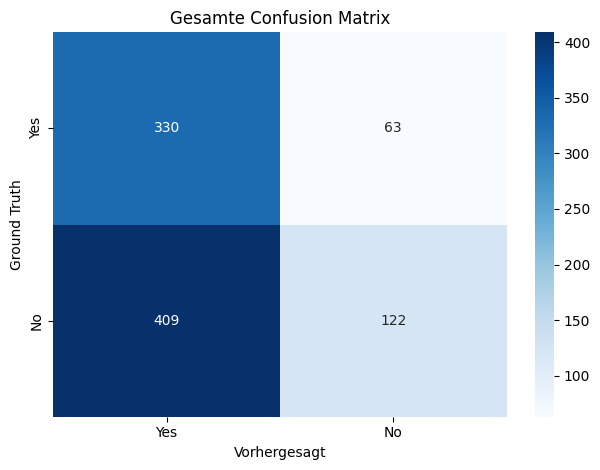


 Confusion Matrices pro Kategorie:

 Kategorie: Competitive Restriction Exception
Confusion Matrix:
[[ 52  21]
 [106  50]]
              precision    recall  f1-score   support

         Yes       0.33      0.70      0.45        74
          No       0.70      0.32      0.44       158

   micro avg       0.45      0.44      0.44       232
   macro avg       0.52      0.51      0.44       232
weighted avg       0.58      0.44      0.44       232



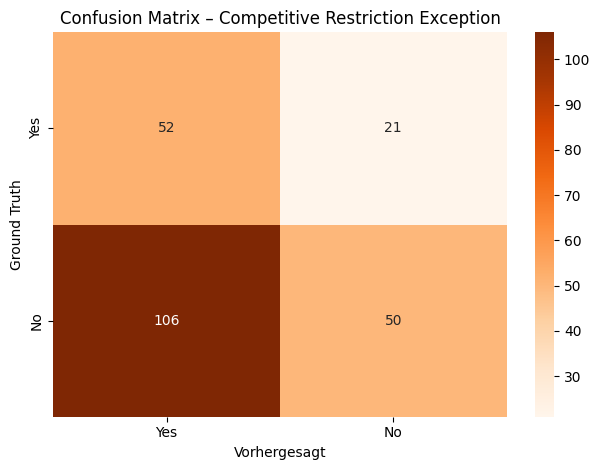


 Kategorie: Non-Compete
Confusion Matrix:
[[107   7]
 [ 91  26]]
              precision    recall  f1-score   support

         Yes       0.54      0.94      0.69       114
          No       0.79      0.22      0.34       118

   micro avg       0.58      0.57      0.57       232
   macro avg       0.66      0.58      0.52       232
weighted avg       0.67      0.57      0.51       232



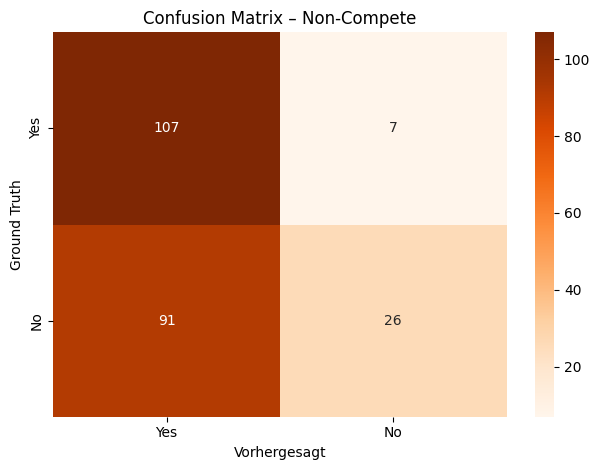


 Kategorie: Exclusivity
Confusion Matrix:
[[141  33]
 [ 38  21]]
              precision    recall  f1-score   support

         Yes       0.79      0.81      0.80       174
          No       0.39      0.36      0.37        59

    accuracy                           0.70       233
   macro avg       0.59      0.58      0.59       233
weighted avg       0.69      0.70      0.69       233



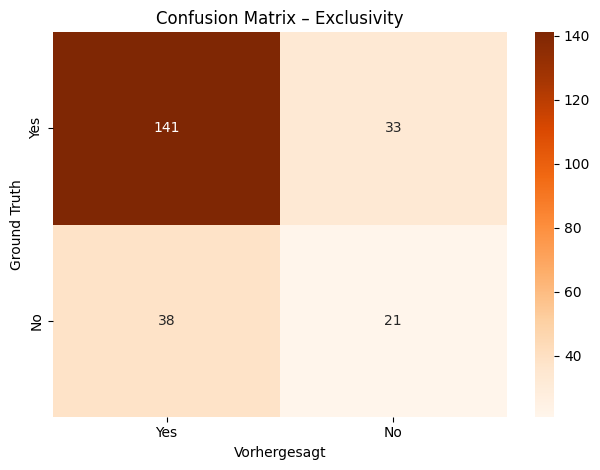


 Kategorie: No-Solicit of Customers
Confusion Matrix:
[[ 30   2]
 [174  25]]
              precision    recall  f1-score   support

         Yes       0.15      0.94      0.25        32
          No       0.93      0.13      0.22       199

    accuracy                           0.24       231
   macro avg       0.54      0.53      0.24       231
weighted avg       0.82      0.24      0.23       231



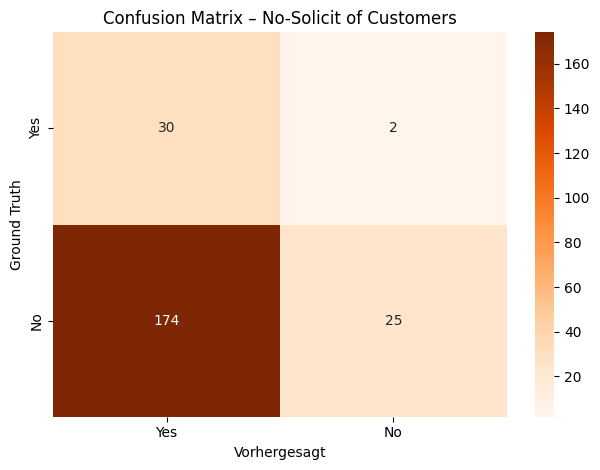

In [55]:
#Evaluation

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

#  1. Kopien der Daten
df_contract_and_answer = df.copy(deep=True)
df_filtered_label_report = filtered_label_report.copy(deep=True)

#  2. Kategorien-Mapping
category_map2 = {
    "competitive restriction": "Competitive Restriction Exception",
    "compete": "Non-Compete",
    "exclusive": "Exclusivity",
    "solicit": "No-Solicit of Customers"
}
#  3. Ground Truth ermitteln
def get_ground_truth(row):
    contract = row["contract"]
    question = row["question"]

    for key in category_map2:
        if key in question.lower():
            category = category_map2[key]
            break
    else:
        return "Unknown"

    annotation = df_filtered_label_report[df_filtered_label_report["Filename"].str.startswith(contract)]
    if not annotation.empty:
        text = annotation.iloc[0][category]
        return "Yes" if pd.notna(text) and text.strip() != "" else "No"
    else:
        return "Unknown"

#  4. GT zuweisen
df_contract_and_answer["ground_truth"] = df_contract_and_answer.apply(get_ground_truth, axis=1)

#  5. Kategorie als neue Spalte speichern
def extract_category(row):
    for key, val in category_map2.items():
        if key in row["question"].lower():
            return val
    return "Unknown"

df_contract_and_answer["category"] = df_contract_and_answer.apply(extract_category, axis=1)

#  6. Nur Yes/No Fälle
df_eval = df_contract_and_answer[df_contract_and_answer["ground_truth"].isin(["Yes", "No"])].copy()


#  GESAMT: Confusion Matrix

print(" GESAMT: Confusion Matrix")
y_true_rag = df_eval["ground_truth"]
y_pred_rag = df_eval["rag_exists"]

cm_rag = confusion_matrix(y_true_rag, y_pred_rag, labels=["Yes", "No"])
print("Confusion Matrix:")
print(cm_rag)
print(classification_report(y_true_rag, y_pred_rag, labels=["Yes", "No"]))

# Visualisierung
sns.heatmap(cm_rag, annot=True, fmt="d", cmap="Blues", xticklabels=["Yes", "No"], yticklabels=["Yes", "No"])
plt.xlabel("Vorhergesagt")
plt.ylabel("Ground Truth")
plt.title("Gesamte Confusion Matrix")
plt.tight_layout()
plt.show()



print("\n Confusion Matrices pro Kategorie:")

for cat in df_eval["category"].unique():
    df_cat = df_eval[df_eval["category"] == cat]
    
    if df_cat.empty:
        continue

    y_true_cat_rag = df_cat["ground_truth"]
    y_pred_cat_rag = df_cat["rag_exists"]

    cm_cat_rag = confusion_matrix(y_true_cat_rag, y_pred_cat_rag, labels=["Yes", "No"])
    print(f"\n Kategorie: {cat}")
    print("Confusion Matrix:")
    print(cm_cat_rag)
    print(classification_report(y_true_cat_rag, y_pred_cat_rag, labels=["Yes", "No"]))

    # Visualisierung
    sns.heatmap(cm_cat_rag, annot=True, fmt="d", cmap="Oranges", xticklabels=["Yes", "No"], yticklabels=["Yes", "No"])
    plt.xlabel("Vorhergesagt")
    plt.ylabel("Ground Truth")
    plt.title(f"Confusion Matrix – {cat}")
    plt.tight_layout()
    plt.show()


### Durchschnittliche Answer Correctness

Spalten im DataFrame für RAGAS: Index(['contract', 'question', 'rag_exists', 'answer', 'ground_truth_label',
       'category', 'ground_truth', 'contexts'],
      dtype='object')
Anzahl Beispiele für die RAGAS-Evaluierung: 329
Starte RAGAS-Evaluierung...


Evaluating:   0%|          | 0/658 [00:00<?, ?it/s]

RAGAS-Ergebnisse (erste Zeilen):


user_input retrieved_contexts  \
0  Does the 2ThemartComInc_19990826_10-12G_EX-10....                 []   
1  Does the ADAMSGOLFINC_03_21_2005-EX-10.17-ENDO...                 []   
2  Does the ADAMSGOLFINC_03_21_2005-EX-10.17-ENDO...                 []   
3  Does the ADAMSGOLFINC_03_21_2005-EX-10.17-ENDO...                 []   
4  Does the ADAPTIMMUNETHERAPEUTICSPLC_04_06_2017...                 []   

                                            response  \
0  The contract specifies a two-year Non-Compete ...   
1  The contract allows the CONSULTANT to endorse ...   
2  The contract restricts the CONSULTANT from end...   
3  The contract grants ADAMS GOLF exclusive right...   
4  The contract prohibits both the Company and it...   

                                           reference  answer_correctness  \
0  i-Escrow shall not run banner advertisements o...            0.083283   
1  Notwithstanding paragraphs 4A, 4B and 4C above...            0.342567   
2  When endorsing a non-competitive product, unde...            0.437930   
3  CONSULTANT hereby gives and grants to ADAMS GO...            0.815469   
4  Neither MD Anderson nor Principal Investigator...            0.411096   

   factual_correctness(mode=f1)  
0                          0.00  
1                          0.44  
2                          0.00  
3                          0.60  
4                          0.00

=== Schlechteste 5 Beispiele nach factual_correctness ===


question  \
0    Does the 2ThemartComInc_19990826_10-12G_EX-10....   
154  Does the ImpresseCorp_20000322_S-1A_EX-10.11_5...   
158  Does the INNOVIVA,INC_08_07_2014-EX-10.1-COLLA...   
163  Does the InvendaCorp_20000828_S-1A_EX-10.2_258...   
170  Does the KIROMICBIOPHARMA,INC_04_08_2020-EX-10...   

                                                answer  \
0    The contract specifies a two-year Non-Compete ...   
154  The contract includes a non-competition clause...   
158  The contract prohibits either party from marke...   
163  The agreement specifies that the parties are j...   
170  The agreement prevents the sale, licensing, or...   

                                          ground_truth  \
0    i-Escrow shall not run banner advertisements o...   
154  Beginning on the Launch Date and continuing du...   
158  Subject to the terms of this Agreement, includ...   
163  Notwithstanding the foregoing, solely for the ...   
170  Kiromic is committed to sharing patents and kn...   

     factual_correctness(mode=f1)  
0                             0.0  
154                           0.0  
158                           0.0  
163                           0.0  
170                           0.0


Durchschnittswerte:
answer_correctness              0.497316
factual_correctness(mode=f1)    0.274681
dtype: float64


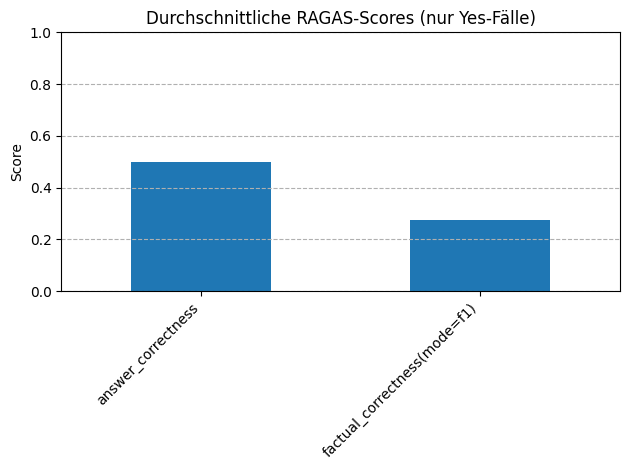

In [38]:
#Mit No Fällen nicht möglich, weil es kein Ground Truth gibt

from datasets import Dataset  
from ragas import evaluate
from ragas.metrics._answer_correctness import AnswerCorrectness
from ragas.metrics._factual_correctness import FactualCorrectness
from ragas.metrics import ResponseRelevancy
import pandas as pd
import matplotlib.pyplot as plt

df_ragas_input = df_contract_and_answer.copy(deep=True)
df_ground_truth_text = filtered_label_report.copy(deep=True)

answer_correctness = AnswerCorrectness()
factual_correctness = FactualCorrectness()



def get_ragas_data(row):
    """
    - Nutzt question & category_map2, um herauszufinden, welche Spalte (Klausel) im Label-Report gemeint ist.
    - Sucht in df_ground_truth_text (mit 'Filename'.str.startswith(contract)) den passenden Vertragseintrag.
    - Gibt den vollständigen Text zurück (oder None, falls nicht gefunden).
    """
    contract = row["contract"]
    question = row["question"]
    
    matched_cat = None
    for key, category in category_map2.items():
        if key in question.lower():
            matched_cat = category
            break
    
    if matched_cat is None:
        # Frage passt zu keiner Spalte
        return pd.Series([None, []], index=["ground_truth_text", "contexts"])
    
    # Finde den passenden Eintrag im label_report
    annotation = df_ground_truth_text[df_ground_truth_text["Filename"].str.startswith(contract)]
    if annotation.empty:
        # Kein passender Datensatz
        return pd.Series([None, []], index=["ground_truth_text", "contexts"])
    
    # Nimm den Text aus der passenden Spalte
    gt_text = annotation.iloc[0][matched_cat]
    # Prüfen, ob Text leer oder NaN
    if pd.isna(gt_text) or str(gt_text).strip() == "":
        return pd.Series([None, []], index=["ground_truth_text", "contexts"])
    

    return pd.Series([str(gt_text).strip(), []], index=["ground_truth_text", "contexts"])


df_ragas_input[["ground_truth_text", "contexts"]] = df_ragas_input.apply(get_ragas_data, axis=1)


df_ragas_input.dropna(subset=["ground_truth_text"], inplace=True)


df_ragas_input = df_ragas_input[df_ragas_input["rag_exists"].str.lower() == "yes"]


df_ragas_input["rag_details"] = df_ragas_input["rag_details"].fillna("")


if "ground_truth" in df_ragas_input.columns:
    df_ragas_input.rename(columns={"ground_truth": "ground_truth_label"}, inplace=True)


df_ragas_input.rename(columns={"ground_truth_text": "ground_truth"}, inplace=True)


df_eval_new = df_ragas_input.copy()

# RAGAS braucht "answer" und "ground_truth"
df_eval_new.rename(columns={
    "rag_details": "answer"
}, inplace=True)

# Entferne evtl. doppelte Spalten
df_eval_new = df_eval_new.loc[:, ~df_eval_new.columns.duplicated()]

print("Spalten im DataFrame für RAGAS:", df_eval_new.columns)


ragas_dataset = Dataset.from_dict({
    "question": df_eval_new["question"].astype(str).tolist(),
    "answer": df_eval_new["answer"].astype(str).tolist(),
    "contexts": df_eval_new["contexts"].tolist(),
    "ground_truth": df_eval_new["ground_truth"].astype(str).tolist()
})

print(f"Anzahl Beispiele für die RAGAS-Evaluierung: {len(ragas_dataset)}")


metrics_to_evaluate = [answer_correctness, factual_correctness]

print("Starte RAGAS-Evaluierung...")
results = evaluate(
    ragas_dataset,
    metrics=metrics_to_evaluate,
    raise_exceptions=False,
    llm=llm,              # Deine LLM-Instanz
    embeddings=embeddings # Falls du welche brauchst
)

results_df = results.to_pandas()
print("RAGAS-Ergebnisse (erste Zeilen):")
display(results_df.head())

# Ergebnisse kombinieren
df_merged = pd.concat([
    df_eval_new.reset_index(drop=True),
    results_df.reset_index(drop=True)
], axis=1)

print("=== Schlechteste 5 Beispiele nach factual_correctness ===")
display(df_merged.sort_values("factual_correctness(mode=f1)").head(5)[["question", "answer", "ground_truth", "factual_correctness(mode=f1)"]])





avg_scores = results_df[["answer_correctness", "factual_correctness(mode=f1)"]].mean()

print("\nDurchschnittswerte:")
print(avg_scores)

# Plot
avg_scores.plot(kind='bar', ylim=(0, 1), title='Durchschnittliche RAGAS-Scores (nur Yes-Fälle)')
plt.ylabel("Score")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

 Durchschnittliche RAGAS-Metriken pro Klausel-Kategorie:


answer_correctness  \
category                                                
No-Solicit of Customers                      0.542630   
Exclusivity                                  0.528022   
Non-Compete                                  0.475217   
Competitive Restriction Exception            0.433978   

                                   factual_correctness(mode=f1)  
category                                                         
No-Solicit of Customers                                0.242333  
Exclusivity                                            0.255714  
Non-Compete                                            0.326355  
Competitive Restriction Exception                      0.238077

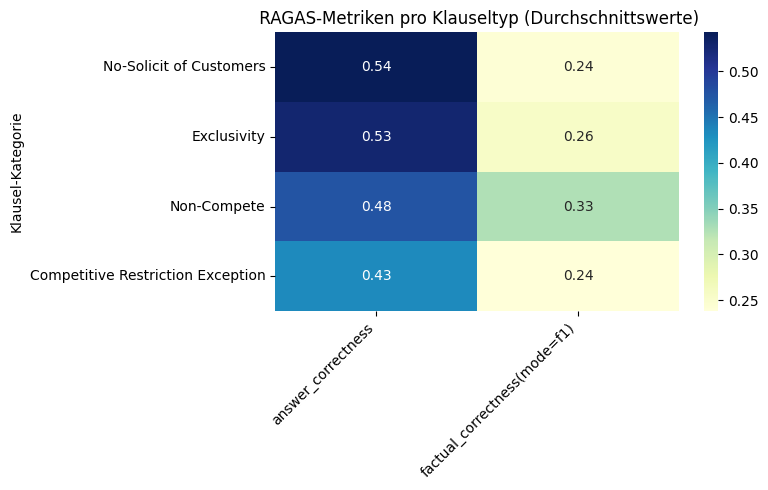

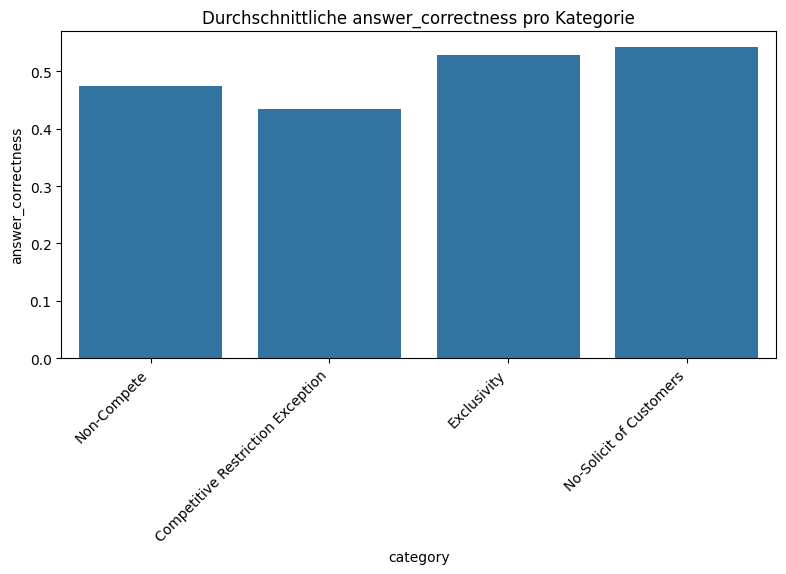

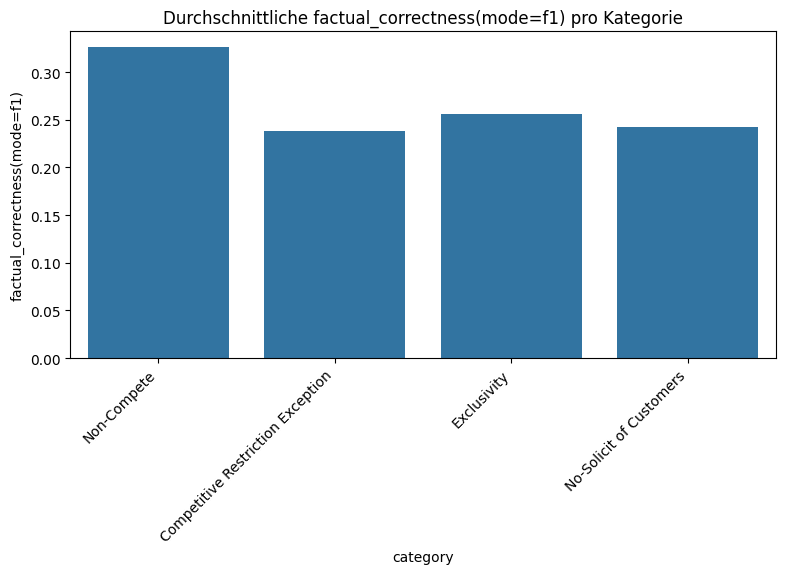

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

#  Kategorie-Spalte erstellen (falls noch nicht vorhanden)
def extract_category(row):
    for key, value in category_map2.items():
        if key in row["question"].lower():
            return value
    return "Unknown"

df_merged["category"] = df_merged.apply(extract_category, axis=1)

#  Durchschnittswerte pro Kategorie berechnen
category_means = df_merged.groupby("category")[
    ["answer_correctness", "factual_correctness(mode=f1)"]
].mean().sort_values("answer_correctness", ascending=False)

print(" Durchschnittliche RAGAS-Metriken pro Klausel-Kategorie:")
display(category_means)

#  Heatmap zur Übersicht
plt.figure(figsize=(8, 5))
sns.heatmap(category_means, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)
plt.title(" RAGAS-Metriken pro Klauseltyp (Durchschnittswerte)")
plt.ylabel("Klausel-Kategorie")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#  Balkendiagramme (pro Metrik)
for metric in ["answer_correctness", "factual_correctness(mode=f1)"]:
    plt.figure(figsize=(8, 4))
    sns.barplot(data=df_merged, x="category", y=metric, errorbar=None)
    plt.tight_layout()
    plt.xticks(rotation=45, ha="right")
    plt.title(f"Durchschnittliche {metric} pro Kategorie")


In [171]:
df_merged.style

Evaluating:   0%|          | 0/923 [00:00<?, ?it/s]

Durchschnittliche response_relevancy nach Ground Truth Label:


ground_truth_label
No     0.387910
Yes    0.453918
Name: answer_relevancy, dtype: float64

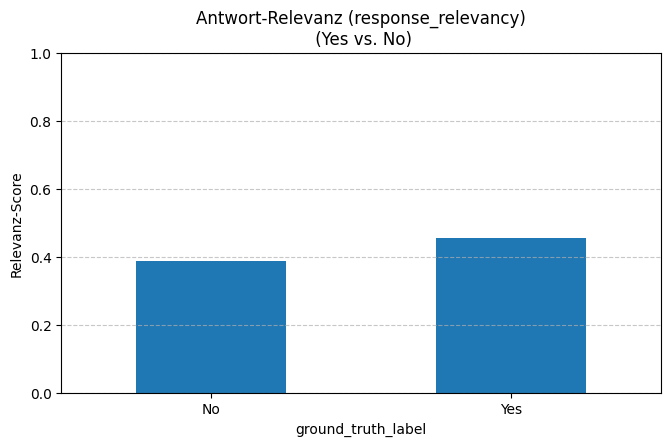

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import ResponseRelevancy

response_relevancy = ResponseRelevancy()


df_resp_eval = df_contract_and_answer[
    df_contract_and_answer["rag_details"].notna() &
    df_contract_and_answer["rag_details"].str.strip().ne("")
].copy()


df_resp_eval.rename(columns={
    "rag_details": "answer",
    "ground_truth": "ground_truth_label"  
}, inplace=True)


df_resp_eval["contexts"] = [[] for _ in range(len(df_resp_eval))]


dataset = Dataset.from_dict({
    "question": df_resp_eval["question"].astype(str).tolist(),
    "answer": df_resp_eval["answer"].astype(str).tolist(),
    "contexts": df_resp_eval["contexts"]
})



result = evaluate(
    dataset,
    metrics=[response_relevancy],
    llm=llm,
    embeddings=embeddings
)


df_scores = result.to_pandas()
df_resp_eval.reset_index(drop=True, inplace=True)
df_combined = pd.concat([df_resp_eval, df_scores], axis=1)


avg_relevancy_by_label = df_combined.groupby("ground_truth_label")["answer_relevancy"].mean()
print("Durchschnittliche response_relevancy nach Ground Truth Label:")
display(avg_relevancy_by_label)


plt.figure(figsize=(8, 5))
avg_relevancy_by_label.plot(
    kind="bar",
    ylim=(0, 1),
    title="Antwort-Relevanz (response_relevancy)\n (Yes vs. No)"
)
plt.ylabel("Relevanz-Score")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.2)
plt.show()

In [155]:
df_combined.style


## KAG

 GESAMT: Confusion Matrix
Confusion Matrix:
[[289 105]
 [267 267]]
              precision    recall  f1-score   support

         Yes       0.52      0.73      0.61       394
          No       0.72      0.50      0.59       534

    accuracy                           0.60       928
   macro avg       0.62      0.62      0.60       928
weighted avg       0.63      0.60      0.60       928



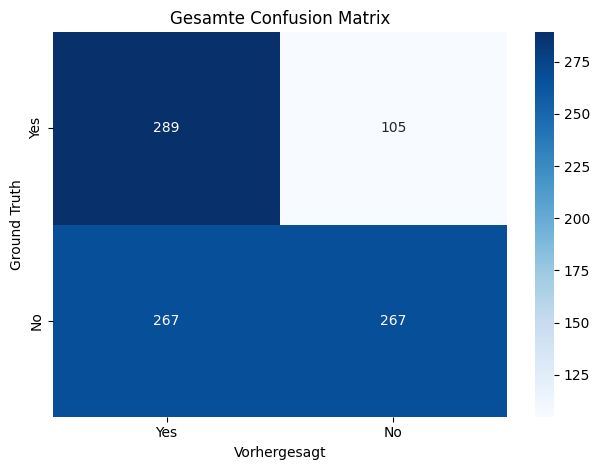


 Confusion Matrices pro Kategorie:

 Kategorie: Non-Compete
Confusion Matrix:
[[79 35]
 [61 57]]
              precision    recall  f1-score   support

         Yes       0.56      0.69      0.62       114
          No       0.62      0.48      0.54       118

    accuracy                           0.59       232
   macro avg       0.59      0.59      0.58       232
weighted avg       0.59      0.59      0.58       232



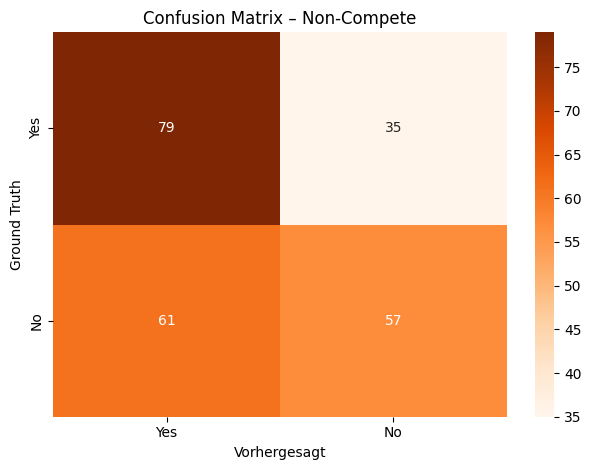


 Kategorie: Exclusivity
Confusion Matrix:
[[134  40]
 [ 32  27]]
              precision    recall  f1-score   support

         Yes       0.81      0.77      0.79       174
          No       0.40      0.46      0.43        59

    accuracy                           0.69       233
   macro avg       0.61      0.61      0.61       233
weighted avg       0.70      0.69      0.70       233



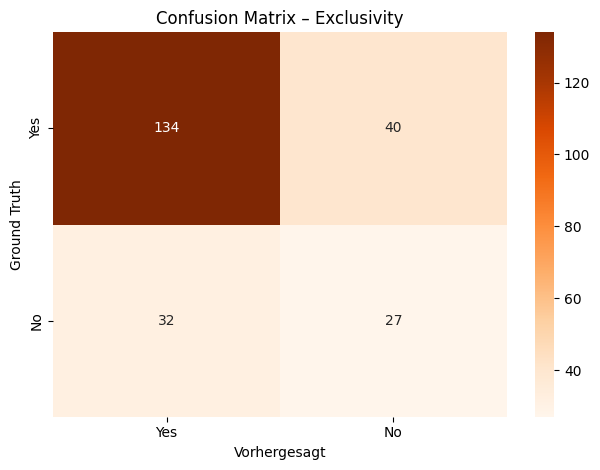


 Kategorie: Competitive Restriction Exception
Confusion Matrix:
[[54 20]
 [96 62]]
              precision    recall  f1-score   support

         Yes       0.36      0.73      0.48        74
          No       0.76      0.39      0.52       158

    accuracy                           0.50       232
   macro avg       0.56      0.56      0.50       232
weighted avg       0.63      0.50      0.51       232



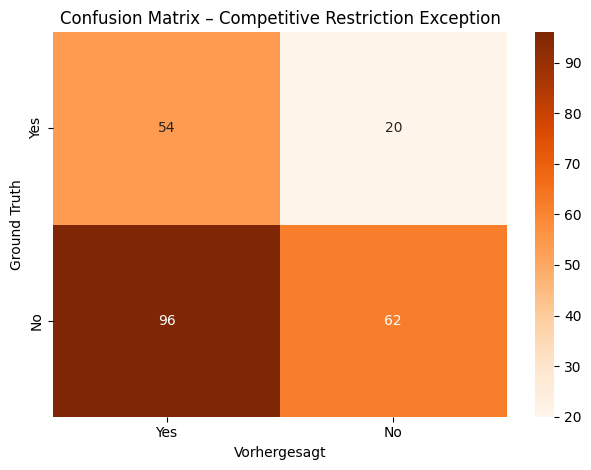


 Kategorie: No-Solicit of Customers
Confusion Matrix:
[[ 22  10]
 [ 78 121]]
              precision    recall  f1-score   support

         Yes       0.22      0.69      0.33        32
          No       0.92      0.61      0.73       199

    accuracy                           0.62       231
   macro avg       0.57      0.65      0.53       231
weighted avg       0.83      0.62      0.68       231



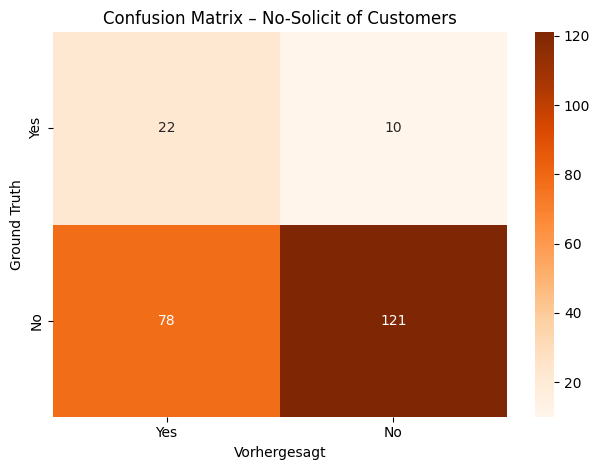

In [56]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
# CSV-Datei laden
kag_snapshot_df = pd.read_csv("final_combined_results3.csv")
kag_snapshot_df = kag_snapshot_df[kag_snapshot_df["status"] != "failed_unexpected"]
kag_snapshot_df.drop(columns=["status"], inplace=True)
df_filtered_label_report = filtered_label_report.copy(deep=True)

# Excel-Datei laden
label_report = pd.read_excel("Label Report - Non-Compete, Exclusivity, No-Solicit of Customers (Group 2).xlsx")

# Mapping der Kategorien
category_map2 = {
    "competitive restriction": "Competitive Restriction Exception",
    "compete": "Non-Compete",
    "exclusive": "Exclusivity",
    "solicit": "No-Solicit of Customers"
}

def get_ground_truth(row):
    contract = row["contract"]
    question = row["question"]

    for key in category_map2:
        if key in question.lower():
            category = category_map2[key]
            break
    else:
        return "Unknown"

    annotation = df_filtered_label_report[df_filtered_label_report["Filename"].str.startswith(contract)]
    if not annotation.empty:
        text = annotation.iloc[0][category]
        return "Yes" if pd.notna(text) and text.strip() != "" else "No"
    else:
        return "Unknown"




def parse_rag_answer(answer):
    try:
        parts = answer.replace("\n", " ").split("(2)")
        hop1_part = parts[0].replace("(1)", "").strip()
        hop2_part = parts[1].strip() if len(parts) > 1 else ""
        
        hop1 = "Yes" if "Yes" in hop1_part else "No" if "No" in hop1_part else "Error"
        hop2 = hop2_part if hop2_part else ""
        return hop1, hop2
    except:
        return "Error", answer


kag_snapshot_df[["kag_exists", "kag_details"]] = kag_snapshot_df["kag_answer"].apply(
    lambda x: pd.Series(parse_rag_answer(x))
)

kag_snapshot_df.drop(columns=["kag_answer"], inplace=True)



#  4. GT zuweisen
kag_snapshot_df["ground_truth"] = kag_snapshot_df.apply(get_ground_truth, axis=1)

#  5. Kategorie als neue Spalte speichern
def extract_category(row):
    for key, val in category_map2.items():
        if key in row["question"].lower():
            return val
    return "Unknown"

kag_snapshot_df["category"] = kag_snapshot_df.apply(extract_category, axis=1)

#  6. Nur Yes/No Fälle
df_eval = kag_snapshot_df[kag_snapshot_df["ground_truth"].isin(["Yes", "No"])].copy()


print(" GESAMT: Confusion Matrix")
y_true_kag = df_eval["ground_truth"]
y_pred_kag = df_eval["kag_exists"]

cm_kag = confusion_matrix(y_true_kag, y_pred_kag, labels=["Yes", "No"])
print("Confusion Matrix:")
print(cm_kag)
print(classification_report(y_true_kag, y_pred_kag, labels=["Yes", "No"]))

# Visualisierung
sns.heatmap(cm_kag, annot=True, fmt="d", cmap="Blues", xticklabels=["Yes", "No"], yticklabels=["Yes", "No"])
plt.xlabel("Vorhergesagt")
plt.ylabel("Ground Truth")
plt.title("Gesamte Confusion Matrix")
plt.tight_layout()
plt.show()



print("\n Confusion Matrices pro Kategorie:")

for cat in df_eval["category"].unique():
    df_cat = df_eval[df_eval["category"] == cat]
    
    if df_cat.empty:
        continue

    y_true_cat_kag = df_cat["ground_truth"]
    y_pred_cat_kag = df_cat["kag_exists"]

    cm_cat_kag = confusion_matrix(y_true_cat_kag, y_pred_cat_kag, labels=["Yes", "No"])
    print(f"\n Kategorie: {cat}")
    print("Confusion Matrix:")
    print(cm_cat_kag)
    print(classification_report(y_true_cat_kag,y_pred_cat_kag, labels=["Yes", "No"]))

    # Visualisierung
    sns.heatmap(cm_cat_kag , annot=True, fmt="d", cmap="Oranges", xticklabels=["Yes", "No"], yticklabels=["Yes", "No"])
    plt.xlabel("Vorhergesagt")
    plt.ylabel("Ground Truth")
    plt.title(f"Confusion Matrix – {cat}")
    plt.tight_layout()
    plt.show()


In [70]:
kag_snapshot_df.style

Spalten im DataFrame für RAGAS: Index(['contract', 'question', 'kag_exists', 'answer', 'ground_truth_label',
       'category', 'ground_truth', 'contexts'],
      dtype='object')
Anzahl Beispiele für die RAGAS-Evaluierung: 289
Starte RAGAS-Evaluierung...


Evaluating:   0%|          | 0/578 [00:00<?, ?it/s]

RAGAS-Ergebnisse (erste Zeilen):


user_input  \
0                                                          Does the LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGREEMENT contract grant one party exclusive rights to provide certain goods or services, and if so, does it also prevent that party from entering into similar agreements with third parties?   
1                                            Is there a provision in the LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGREEMENT contract that prohibits a party from soliciting or doing business with the customers or clients of the other party, and if so, does it specify a duration for this prohibition?   
2                                                       Does the ADAMSGOLFINC_03_21_2005-EX-10.17-ENDORSEMENT AGREEMENT contract grant one party exclusive rights to provide certain goods or services, and if so, does it also prevent that party from entering into similar agreements with third parties?   
3                    Does the ADAMSGOLFINC_03_21_2005-EX-10.17-ENDORSEMENT AGREEMENT contract include a clause that restricts a party from competing or engaging in a business activity that competes with the other party, and if so, does it specify a time frame or geographic area for this restriction?   
4  Does the ADAMSGOLFINC_03_21_2005-EX-10.17-ENDORSEMENT AGREEMENT contract contain an exception or carve-out to any competitive restriction, allowing certain competitive activities or partnerships that would otherwise be prohibited, and if so, does it specify the activities or partnerships allowed?   

  retrieved_contexts  \
0                 []   
1                 []   
2                 []   
3                 []   
4                 []   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       response  \
0                                                                                                                                                                      The LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGREEMENT grants one party exclusive rights to provide certain goods or services. Such exclusivity is typically established to ensure that the distributor has a competitive advantage in the market for the specified products. Additionally, agreements of this nature often include clauses that prevent the exclusive party from entering into similar agreements with third parties, thereby protecting both parties' interests and maintaining market control over the designated goods or services. These restrictions are designed to safeguard the investment and efforts made by the distributor in promoting and selling the specific products.   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                             The LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGREEMENT does contain a provision that prohibits a party from soliciting or doing business with the customers

=== Schlechteste 5 Beispiele nach factual_correctness ===


question  \
73                                                                                 Does the PapaJohnsInternationalInc_20190617_8-K_EX-10.1_11707365_EX-10.1_Endorsement Agreement contract grant one party exclusive rights to provide certain goods or services, and if so, does it also prevent that party from entering into similar agreements with third parties?   
171                                                 Does the AURASYSTEMSINC_06_16_2010-EX-10.25-STRATEGIC ALLIANCE AGREEMENT contract contain an exception or carve-out to any competitive restriction, allowing certain competitive activities or partnerships that would otherwise be prohibited, and if so, does it specify the activities or partnerships allowed?   
167  Does the AudibleInc_20001113_10-Q_EX-10.32_2599586_EX-10.32_Co-Branding Agreement_ Marketing Agreement_ Investment Distribution Agreement contract include a clause that restricts a party from competing or engaging in a business activity that competes with the other party, and if so, does it specify a time frame or geographic area for this restriction?   
30                                                                                                            Does the WORLDWIDESTRATEGIESINC_11_02_2005-EX-10-RESELLER AGREEMENT contract grant one party exclusive rights to provide certain goods or services, and if so, does it also prevent that party from entering into similar agreements with third parties?   
164                                                                                                     Does the GOLDRESOURCECORP_12_11_2008-EX-10.1-STRATEGIC ALLIANCE AGREEMENT contract grant one party exclusive rights to provide certain goods or services, and if so, does it also prevent that party from entering into similar agreements with third parties?   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       answer  \
73                                                                                                                                                          The PapaJohnsInternationalInc_20190617_8-K_EX-10.1_11707365_EX-10.1_Endorsement Agreement grants exclusive rights to Papa John's regarding the endorsement of their "ESSI Natural Supplementation Products." The agreement contains provisions that prohibit the Talent from endorsing or making appearances on behalf of any products that directly compete with EcoScience Solutions Inc.'s products during the term of the agreement. This exclusivity prevents the Talent from entering into similar agreements with third parties for competing products, thereby ensuring that Papa John's maintains a competitive advantage in the market.   
171                                                                                                                                  The AURASYSTEMSINC_06_16_2010-EX-10.25-STRATEGIC ALLIANCE AGREEMENT contains exceptions to competitive restrictions. Specifically, it allows for activities and partnerships established under the strategic alliance agreement, permitting joint marketing and sales efforts between Aura Systems Inc. and Zanotti East Inc. while prohibiting competition regarding certain systems. The agreement mandates the development of a joint marketing plan and a joint sales plan for coopera


Durchschnittswerte:
answer_correctness              0.601144
factual_correctness(mode=f1)    0.406055
dtype: float64


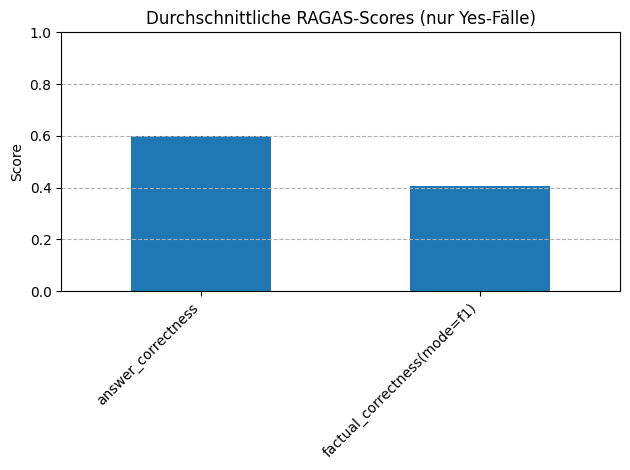

In [57]:
#Mit No Fällen nicht möglich, weil es kein Ground Truth gibt

from datasets import Dataset  
from ragas import evaluate
from ragas.metrics._answer_correctness import AnswerCorrectness
from ragas.metrics._factual_correctness import FactualCorrectness
from ragas.metrics import ResponseRelevancy
import pandas as pd
import matplotlib.pyplot as plt

df_ragas_input = kag_snapshot_df.copy(deep=True)
df_ground_truth_text = filtered_label_report.copy(deep=True)

answer_correctness = AnswerCorrectness()
factual_correctness = FactualCorrectness()



def get_ragas_data(row):
    """
    - Nutzt question & category_map2, um herauszufinden, welche Spalte (Klausel) im Label-Report gemeint ist.
    - Sucht in df_ground_truth_text (mit 'Filename'.str.startswith(contract)) den passenden Vertragseintrag.
    - Gibt den vollständigen Text zurück (oder None, falls nicht gefunden).
    """
    contract = row["contract"]
    question = row["question"]
    
    matched_cat = None
    for key, category in category_map2.items():
        if key in question.lower():
            matched_cat = category
            break
    
    if matched_cat is None:
        # Frage passt zu keiner Spalte
        return pd.Series([None, []], index=["ground_truth_text", "contexts"])
    
    # Finde den passenden Eintrag im label_report
    annotation = df_ground_truth_text[df_ground_truth_text["Filename"].str.startswith(contract)]
    if annotation.empty:
        return pd.Series([None, []], index=["ground_truth_text", "contexts"])
    
   
    gt_text = annotation.iloc[0][matched_cat]
    
    if pd.isna(gt_text) or str(gt_text).strip() == "":
        return pd.Series([None, []], index=["ground_truth_text", "contexts"])
    
    
    return pd.Series([str(gt_text).strip(), []], index=["ground_truth_text", "contexts"])


df_ragas_input[["ground_truth_text", "contexts"]] = df_ragas_input.apply(get_ragas_data, axis=1)


df_ragas_input.dropna(subset=["ground_truth_text"], inplace=True)


df_ragas_input = df_ragas_input[df_ragas_input["kag_exists"].str.lower() == "yes"]


df_ragas_input["kag_details"] = df_ragas_input["kag_details"].fillna("")



if "ground_truth" in df_ragas_input.columns:
    df_ragas_input.rename(columns={"ground_truth": "ground_truth_label"}, inplace=True)


df_ragas_input.rename(columns={"ground_truth_text": "ground_truth"}, inplace=True)


df_eval_new = df_ragas_input.copy()

# RAGAS braucht "answer" und "ground_truth"
df_eval_new.rename(columns={
    "kag_details": "answer"
}, inplace=True)

# Entferne doppelte Spalten
df_eval_new = df_eval_new.loc[:, ~df_eval_new.columns.duplicated()]

print("Spalten im DataFrame für RAGAS:", df_eval_new.columns)


ragas_dataset = Dataset.from_dict({
    "question": df_eval_new["question"].astype(str).tolist(),
    "answer": df_eval_new["answer"].astype(str).tolist(),
    "contexts": df_eval_new["contexts"].tolist(),
    "ground_truth": df_eval_new["ground_truth"].astype(str).tolist()
})

print(f"Anzahl Beispiele für die RAGAS-Evaluierung: {len(ragas_dataset)}")


metrics_to_evaluate = [answer_correctness, factual_correctness]

print("Starte RAGAS-Evaluierung...")
results = evaluate(
    ragas_dataset,
    metrics=metrics_to_evaluate,
    raise_exceptions=False,
    llm=llm,              # Deine LLM-Instanz
    embeddings=embeddings # Falls du welche brauchst
)

results_df_kag = results.to_pandas()
print("RAGAS-Ergebnisse (erste Zeilen):")
display(results_df_kag.head())

# Ergebnisse kombinieren
df_merged_kag = pd.concat([
    df_eval_new.reset_index(drop=True),
    results_df_kag.reset_index(drop=True)
], axis=1)

print("=== Schlechteste 5 Beispiele nach factual_correctness ===")
display(df_merged_kag.sort_values("factual_correctness(mode=f1)").head(5)[["question", "answer", "ground_truth", "factual_correctness(mode=f1)"]])




avg_scores = results_df_kag[["answer_correctness", "factual_correctness(mode=f1)"]].mean()

print("\nDurchschnittswerte:")
print(avg_scores)

# Plot
avg_scores.plot(kind='bar', ylim=(0, 1), title='Durchschnittliche RAGAS-Scores (nur Yes-Fälle)')
plt.ylabel("Score")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

 Durchschnittliche RAGAS-Metriken pro Klausel-Kategorie:


answer_correctness  \
category                                                
Exclusivity                                  0.618885   
Non-Compete                                  0.586769   
Competitive Restriction Exception            0.585854   
No-Solicit of Customers                      0.582240   

                                   factual_correctness(mode=f1)  
category                                                         
Exclusivity                                            0.366940  
Non-Compete                                            0.522532  
Competitive Restriction Exception                      0.323148  
No-Solicit of Customers                                0.429545

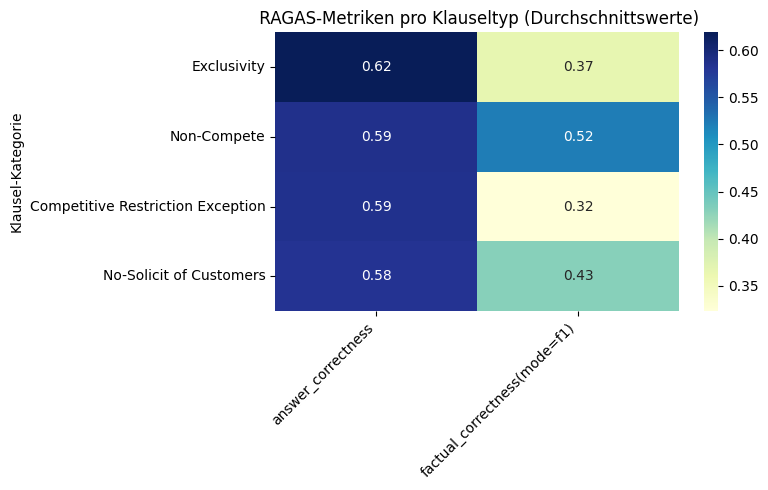

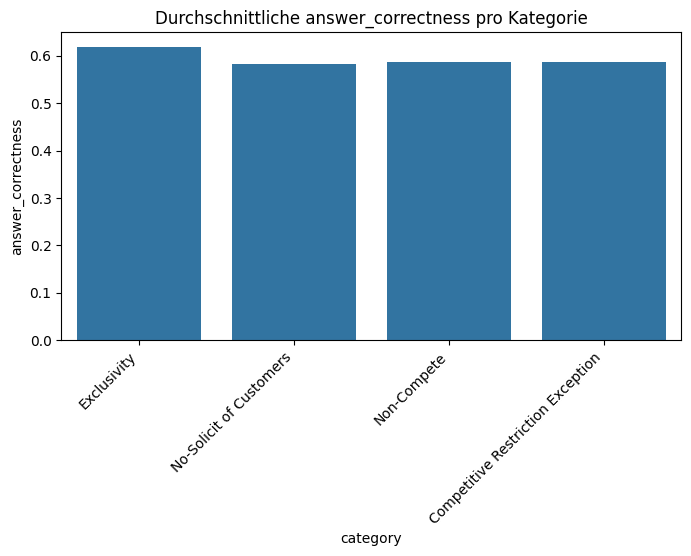

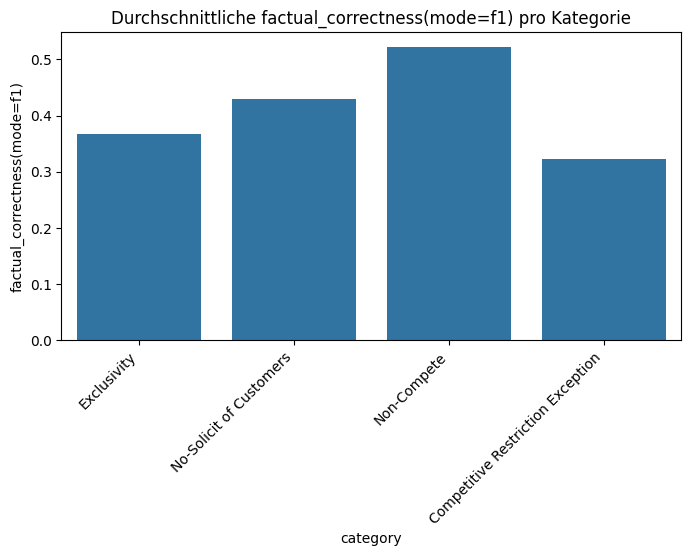

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

#  Kategorie-Spalte erstellen (falls noch nicht vorhanden)
def extract_category(row):
    for key, value in category_map2.items():
        if key in row["question"].lower():
            return value
    return "Unknown"

df_merged_kag["category"] = df_merged_kag.apply(extract_category, axis=1)

#  Durchschnittswerte pro Kategorie berechnen
category_means = df_merged_kag.groupby("category")[
    ["answer_correctness", "factual_correctness(mode=f1)"]
].mean().sort_values("answer_correctness", ascending=False)

print(" Durchschnittliche RAGAS-Metriken pro Klausel-Kategorie:")
display(category_means)

#  Heatmap zur Übersicht
plt.figure(figsize=(8, 5))
sns.heatmap(category_means, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)
plt.title(" RAGAS-Metriken pro Klauseltyp (Durchschnittswerte)")
plt.ylabel("Klausel-Kategorie")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#  Balkendiagramme (pro Metrik)
for metric in ["answer_correctness", "factual_correctness(mode=f1)"]:
    plt.figure(figsize=(8, 4))
    sns.barplot(data=df_merged_kag, x="category", y=metric, errorbar=None)
    plt.xticks(rotation=45, ha="right")
    plt.title(f"Durchschnittliche {metric} pro Kategorie")

Evaluating:   0%|          | 0/928 [00:00<?, ?it/s]

Durchschnittliche response_relevancy nach Ground Truth Label:


ground_truth_label
No     0.421628
Yes    0.407907
Name: answer_relevancy, dtype: float64

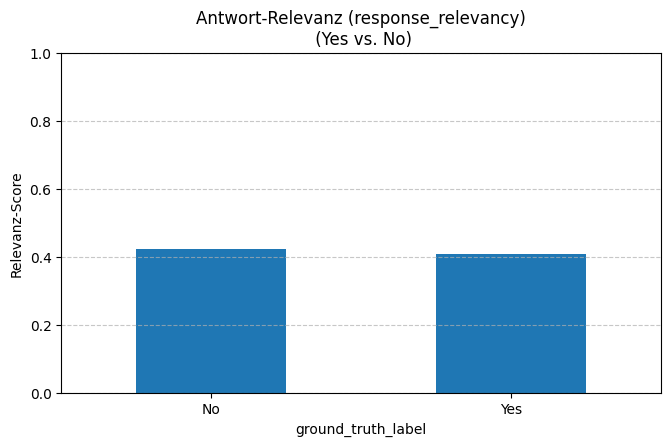

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import ResponseRelevancy

response_relevancy = ResponseRelevancy()


df_resp_eval = kag_snapshot_df[
    kag_snapshot_df["kag_details"].notna() &
    kag_snapshot_df["kag_details"].str.strip().ne("")
].copy()



df_resp_eval.rename(columns={
    "kag_details": "answer",
    "ground_truth": "ground_truth_label"  
}, inplace=True)

df_resp_eval = df_resp_eval[df_resp_eval["ground_truth_label"].isin(["Yes", "No"])]


df_resp_eval["contexts"] = [[] for _ in range(len(df_resp_eval))]


dataset = Dataset.from_dict({
    "question": df_resp_eval["question"].astype(str).tolist(),
    "answer": df_resp_eval["answer"].astype(str).tolist(),
    "contexts": df_resp_eval["contexts"]
})



result = evaluate(
    dataset,
    metrics=[response_relevancy],
    llm=llm,
    embeddings=embeddings
)


df_scores_kag = result.to_pandas()
df_resp_eval.reset_index(drop=True, inplace=True)
df_combined_kag = pd.concat([df_resp_eval, df_scores], axis=1)


avg_relevancy_by_label = df_combined_kag.groupby("ground_truth_label")["answer_relevancy"].mean()
print("Durchschnittliche response_relevancy nach Ground Truth Label:")
display(avg_relevancy_by_label)


plt.figure(figsize=(8, 5))
avg_relevancy_by_label.plot(
    kind="bar",
    ylim=(0, 1),
    title="Antwort-Relevanz (response_relevancy)\n (Yes vs. No)"
)
plt.ylabel("Relevanz-Score")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.2)
plt.show()

## Vergleich RAG/KAG

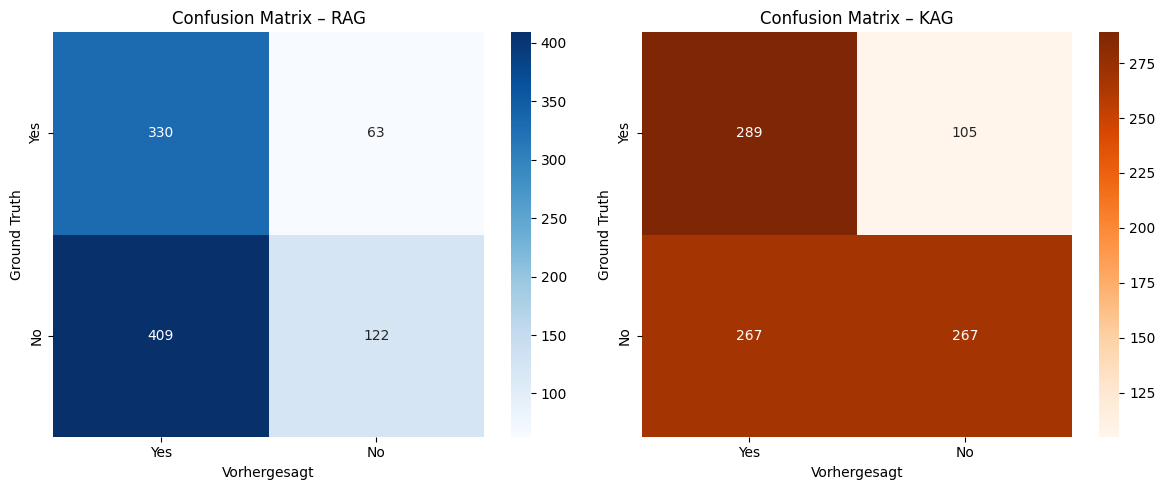

In [74]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_rag, annot=True, fmt="d", cmap="Blues", xticklabels=["Yes", "No"], yticklabels=["Yes", "No"], ax=axs[0])
axs[0].set_title("Confusion Matrix – RAG")
axs[0].set_xlabel("Vorhergesagt")
axs[0].set_ylabel("Ground Truth")

sns.heatmap(cm_kag , annot=True, fmt="d", cmap="Oranges", xticklabels=["Yes", "No"], yticklabels=["Yes", "No"], ax=axs[1])
axs[1].set_title("Confusion Matrix – KAG")
axs[1].set_xlabel("Vorhergesagt")
axs[1].set_ylabel("Ground Truth")

plt.tight_layout()
plt.show()

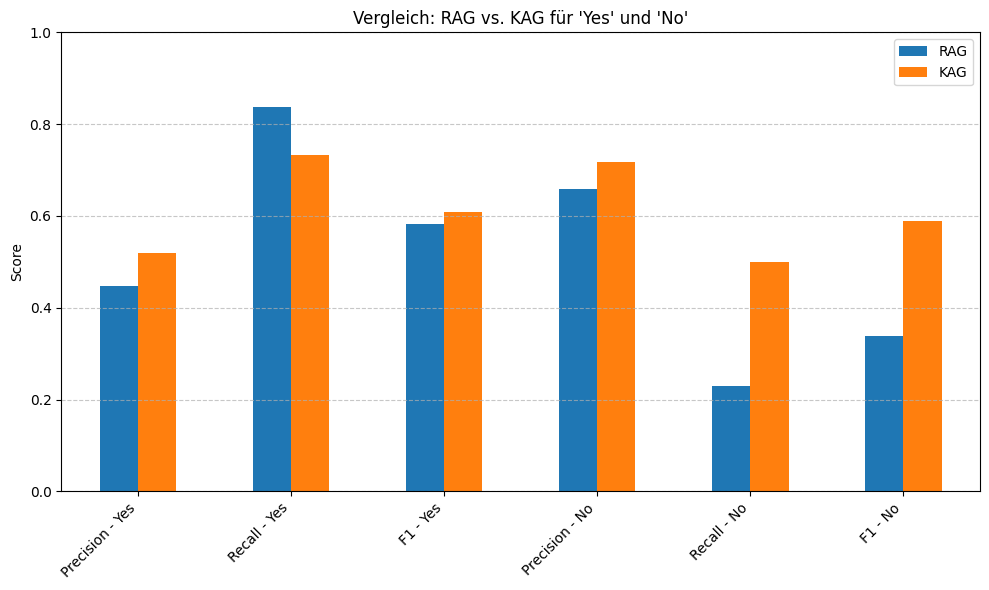

In [75]:
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

# Beispiel: RAG Report
report_rag = classification_report(y_true_rag, y_pred_rag, labels=["Yes", "No"], output_dict=True)
report_kag = classification_report(y_true_kag, y_pred_kag, labels=["Yes", "No"], output_dict=True)

# Extrahieren & zusammenführen
comparison_df = pd.DataFrame({
    "Precision - Yes": [report_rag["Yes"]["precision"], report_kag["Yes"]["precision"]],
    "Recall - Yes":    [report_rag["Yes"]["recall"],    report_kag["Yes"]["recall"]],
    "F1 - Yes":        [report_rag["Yes"]["f1-score"],  report_kag["Yes"]["f1-score"]],
    "Precision - No":  [report_rag["No"]["precision"],  report_kag["No"]["precision"]],
    "Recall - No":     [report_rag["No"]["recall"],     report_kag["No"]["recall"]],
    "F1 - No":         [report_rag["No"]["f1-score"],   report_kag["No"]["f1-score"]],
}, index=["RAG", "KAG"])

# Balkendiagramm
comparison_df.T.plot(kind="bar", figsize=(10, 6), ylim=(0, 1))
plt.title("Vergleich: RAG vs. KAG für 'Yes' und 'No'")
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


 Prozentuale Verbesserung von KAG gegenüber RAG (in PP):


Precision - Yes     7.32
Recall - Yes      -10.41
F1 - Yes            2.59
Precision - No      5.83
Recall - No        27.15
F1 - No            25.00
dtype: float64

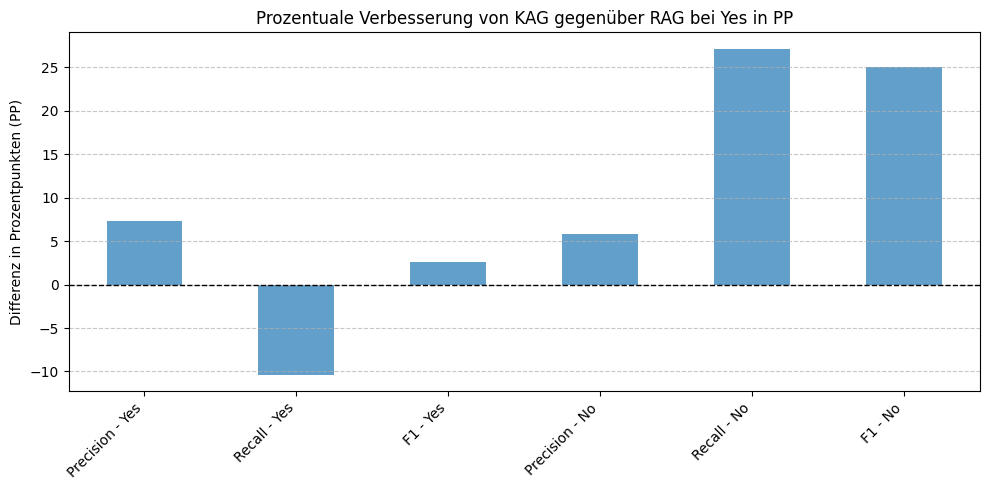

In [106]:
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt


report_rag = classification_report(y_true_rag, y_pred_rag, labels=["Yes", "No"], output_dict=True)
report_kag = classification_report(y_true_kag, y_pred_kag, labels=["Yes", "No"], output_dict=True)

# DataFrame mit den wichtigsten Metriken
comparison_df = pd.DataFrame({
    "Precision - Yes": [report_rag["Yes"]["precision"], report_kag["Yes"]["precision"]],
    "Recall - Yes":    [report_rag["Yes"]["recall"],    report_kag["Yes"]["recall"]],
    "F1 - Yes":        [report_rag["Yes"]["f1-score"],  report_kag["Yes"]["f1-score"]],
    "Precision - No":  [report_rag["No"]["precision"],  report_kag["No"]["precision"]],
    "Recall - No":     [report_rag["No"]["recall"],     report_kag["No"]["recall"]],
    "F1 - No":         [report_rag["No"]["f1-score"],   report_kag["No"]["f1-score"]],
}, index=["RAG", "KAG"])

# Prozentuale Verbesserung (KAG vs. RAG)
percentage_diff = (comparison_df.loc["KAG"] - comparison_df.loc["RAG"]) * 100
percentage_diff = percentage_diff.round(2)

# Ergebnisse anzeigen
print(" Prozentuale Verbesserung von KAG gegenüber RAG (in PP):")
display(percentage_diff)

# Plot
plt.figure(figsize=(10, 5))
percentage_diff.plot(kind="bar", alpha=0.7)
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.title("Prozentuale Verbesserung von KAG gegenüber RAG bei Yes und No in PP")
plt.ylabel("Differenz in Prozentpunkten (PP)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

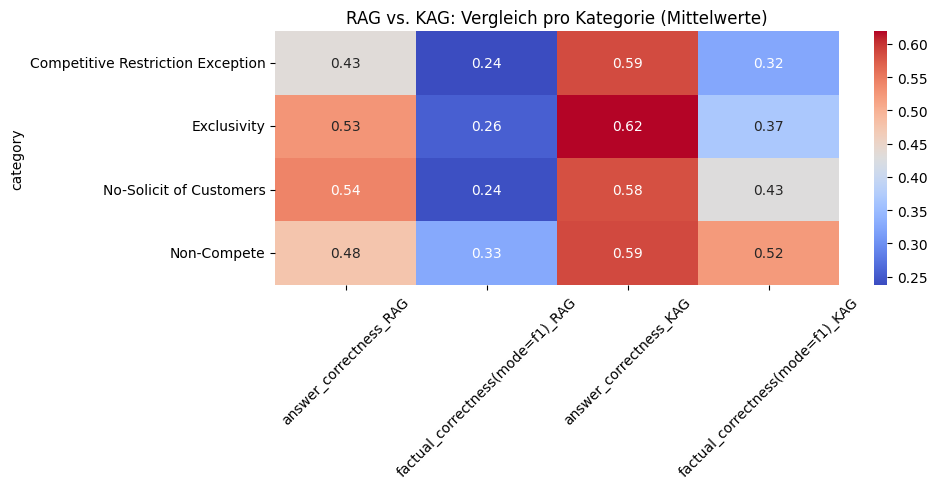

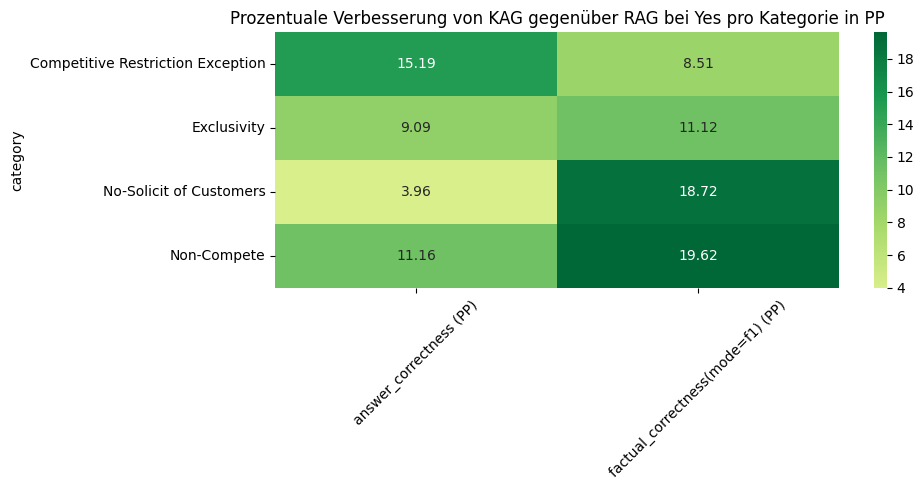

 Prozentuale Unterschiede (KAG im Vergleich zu RAG):


answer_correctness (PP)  \
category                                                     
Competitive Restriction Exception                    15.19   
Exclusivity                                           9.09   
No-Solicit of Customers                               3.96   
Non-Compete                                          11.16   

                                   factual_correctness(mode=f1) (PP)  
category                                                              
Competitive Restriction Exception                               8.51  
Exclusivity                                                    11.12  
No-Solicit of Customers                                        18.72  
Non-Compete                                                    19.62

In [107]:
# Mittelwerte pro Kategorie
rag_means = df_merged.groupby("category")[["answer_correctness", "factual_correctness(mode=f1)"]].mean()
kag_means = df_merged_kag.groupby("category")[["answer_correctness", "factual_correctness(mode=f1)"]].mean()

# Kombinieren für direkte Visualisierung
combined = rag_means.join(kag_means, lsuffix="_RAG", rsuffix="_KAG")

#  Heatmap: Mittelwerte
plt.figure(figsize=(10, 5))
sns.heatmap(combined, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("RAG vs. KAG: Vergleich pro Kategorie (Mittelwerte)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#  Prozentuale Veränderung von KAG zu RAG
percent_diff = (kag_means - rag_means) * 100 
percent_diff = percent_diff.round(2)
percent_diff.columns = [col + " (PP)" for col in percent_diff.columns]

#  Heatmap: Prozentuale Verbesserung (+ bedeutet KAG besser)
plt.figure(figsize=(10, 5))
sns.heatmap(percent_diff, annot=True, fmt=".2f", center=0, cmap="RdYlGn")
plt.title("Prozentuale Verbesserung von KAG gegenüber RAG bei Yes pro Kategorie in PP")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Ausgabe als Tabelle
print(" Prozentuale Unterschiede (KAG im Vergleich zu RAG):")
display(percent_diff)

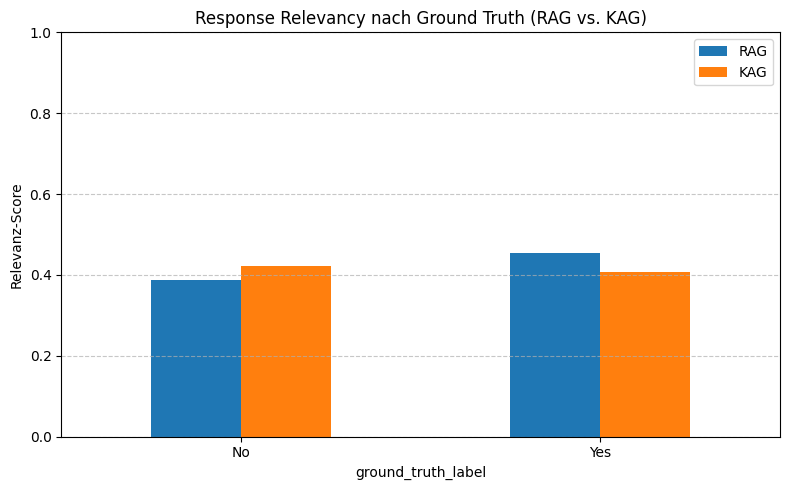

In [78]:
# Mittelwerte extrahieren
avg_relevancy_kag = df_combined_kag.groupby("ground_truth_label")["answer_relevancy"].mean()
avg_relevancy_rag = df_combined.groupby("ground_truth_label")["answer_relevancy"].mean()

# Zusammenfassen
df_relevancy_compare = pd.DataFrame({
    "RAG": avg_relevancy_rag,
    "KAG": avg_relevancy_kag
})

#  Vergleichs-Plot
df_relevancy_compare.plot(kind="bar", ylim=(0, 1), figsize=(8, 5), title="Response Relevancy nach Ground Truth (RAG vs. KAG)")
plt.ylabel("Relevanz-Score")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()